# ZIKV DMS analysis in selections with mAb ZKA64

CK prepped samples for deep mutational scanning using known broadly neutralizing antibodies: EDE1-C8, EDE1-C10, and MZ4 alongside ZIKV-targeted mAbs ZKA64 and ZV-67 as positive controls. The virus library is a ZIKV MR766 E-protein virus library first described in Sourisseau et al J Virology.


**EDE1-C8** was prepared at two concentrations, 1600 ng/mL ("C8_1600") and 800 ng/mL ("C8_800").

**EDE1-C10** was prepared at two concentrations, 300 ng/mL ("C10_300") and 150 ng/mL ("C10_150").

**MZ4** was prepared at three concentrations, 4800 ng/mL ("MZ4_4800"), 2400 ng/mL ("MZ4_2400") and 1200 ng/mL ("MZ4_1200").

**ZKA64** was prepared at a single concentration, 750 ng/mL ("ZKA64_750"). 

**ZV-67** was prepared at two concentrations, 80 ug/mL ("ZV67_80000") and 40 ug/mL ("ZV67_40000").

All antibody concentrations were incubated with 800,000 IU (MOI 1) of virus library and allowed to infect Vero cells for 24 hours prior to isolating total RNA - see [CK018](https://benchling.com/s/etr-YtBt2dzXr60FGcLKYF1C?m=slm-zQusZO8o9Qc9Egy4lYhe) for details. 

Viral cDNA libraries were generated for next-generation sequencing as outlined in [CK019](https://benchling.com/s/etr-Vp41lo9pFVD1ZcXYw0bM?m=slm-m2YLmBU986a39SRUKDYz).


In [1]:
# import tools
import os
import glob
import numpy
import pandas as pd

from Bio import SeqIO

import dms_tools2
from dms_tools2.ipython_utils import showPDF

In [2]:
# set use-existing clause for dms_tools2
use_existing = 'yes'

In [3]:
# ID input/output directories
samplelist = './data/samplelist.csv'
datadir = './data/'
resultsdir = './results/'
os.makedirs(resultsdir, exist_ok=True)

In [4]:
# reference sequences
Erefseq = './data/E.fasta'
subamplicon_alignspecs = './data/subamplicon_alignspecs.txt'

In [5]:
# read in E protein sequence data 
refseq = SeqIO.read(Erefseq, 'fasta')
E_seq = refseq.seq
E_prot = E_seq.translate()

# Bio.SeqIO documention https://biopython.org/wiki/SeqIO

In [6]:
# read in sample list and add the sampleID 'name'
samples = (pd.read_csv(samplelist, index_col=False))
# pd.set_option('display.max_colwidth', None)
# code necessary for more recent versions of pandas (1.above) to set max column width

samples.insert(0, 'name', (samples['library'] + '-' + samples['selection']))
samples.style.hide_index()

name,library,selection,antibody,percent_infectivity,R1
lib1-C10-150,lib1,C10-150,EDE1-C10,0.51%,/fh/fast/bloom_j/computational_notebooks/ckikawa/2022/ZIKV_E_DMS_GooLab/data/concat_fastq/concat_fastq_out/lib1_C10_150_R1.fastq.gz
lib1-C10-300,lib1,C10-300,EDE1-C10,0.11%,/fh/fast/bloom_j/computational_notebooks/ckikawa/2022/ZIKV_E_DMS_GooLab/data/concat_fastq/concat_fastq_out/lib1_C10_300_R1.fastq.gz
lib1-C8-1600,lib1,C8-1600,EDE1-C8,0.01%,/fh/fast/bloom_j/computational_notebooks/ckikawa/2022/ZIKV_E_DMS_GooLab/data/concat_fastq/concat_fastq_out/lib1_C8_1600_R1.fastq.gz
lib1-C8-800,lib1,C8-800,EDE1-C8,0.57%,/fh/fast/bloom_j/computational_notebooks/ckikawa/2022/ZIKV_E_DMS_GooLab/data/concat_fastq/concat_fastq_out/lib1_C8_800_R1.fastq.gz
lib1-MZ4-1200,lib1,MZ4-1200,MZ4,5.22%,/fh/fast/bloom_j/computational_notebooks/ckikawa/2022/ZIKV_E_DMS_GooLab/data/concat_fastq/concat_fastq_out/lib1_MZ4_1200_R1.fastq.gz
lib1-MZ4-2400,lib1,MZ4-2400,MZ4,0.98%,/fh/fast/bloom_j/computational_notebooks/ckikawa/2022/ZIKV_E_DMS_GooLab/data/concat_fastq/concat_fastq_out/lib1_MZ4_2400_R1.fastq.gz
lib1-MZ4-4800,lib1,MZ4-4800,MZ4,0.46%,/fh/fast/bloom_j/computational_notebooks/ckikawa/2022/ZIKV_E_DMS_GooLab/data/concat_fastq/concat_fastq_out/lib1_MZ4_4800_R1.fastq.gz
lib1-ZKA64-750,lib1,ZKA64-750,ZKA-64,0.57%,/fh/fast/bloom_j/computational_notebooks/ckikawa/2022/ZIKV_E_DMS_GooLab/data/concat_fastq/concat_fastq_out/lib1_ZKA64_750_R1.fastq.gz
lib1-ZV67-40000,lib1,ZV67-40000,ZV-67,0.84%,/fh/fast/bloom_j/computational_notebooks/ckikawa/2022/ZIKV_E_DMS_GooLab/data/concat_fastq/concat_fastq_out/lib1_ZV67_40000_R1.fastq.gz
lib1-ZV67-80000,lib1,ZV67-80000,ZV-67,0.26%,/fh/fast/bloom_j/computational_notebooks/ckikawa/2022/ZIKV_E_DMS_GooLab/data/concat_fastq/concat_fastq_out/lib1_ZV67_80000_R1.fastq.gz


In [7]:
# read in align specs
with open (subamplicon_alignspecs, 'r') as file:
    alignspecs = file.read().replace('\n','')
alignspecs

'1,303,33,38 304,609,38,40 610,903,41,36 904,1200,41,37 1201,1512,36,35'

In [8]:
# process deep sequencing data: run dms2_batch_subamp

# make folder where codon counts will go
codons_batch_subamp = os.path.join(resultsdir + 'codoncounts')
os.makedirs(codons_batch_subamp, exist_ok=True)

# tell me if sample path is missing
for c in samples['R1']:
    if c == 'NaN':
       raise ValueError('samples is missing a file path')

# create df and export csv with only name/R1 for dms2_batch_subamp   
batchfile = os.path.join(datadir + 'batchSubampIDs.csv')
samples[['name','R1']].to_csv(batchfile, index=False)

#use existing data
use_existing = 'no'

# standard trim in Bloom lab analyses is 200 bp
# from documentation: "removes low-quality nucleotides that tend to be at the end of long reads"
R1TRIM = 200
R2TRIM = 200

#needs a name to run
baka = ! dms2_batch_bcsubamp \
    --batchfile {batchfile} \
    --refseq {Erefseq} \
    --alignspecs {alignspecs} \
    --outdir {codons_batch_subamp} \
    --summaryprefix summary \
    --R1trim 200 \
    --R2trim 200 \
    --ncpus 16 \
    --use_existing {use_existing}

# ! executes following code in the command line

# add column to df.samples that includes filepath to each codoncounts.csv
samples['codoncounts'] = codons_batch_subamp + '/' + samples['name'] + '_codoncounts.csv'

# tell me how you did
print(f'dms2_batch_bcsubamp {dms_tools2.__version__} aligned sequencing data and created codon count files in {codons_batch_subamp}')

dms2_batch_bcsubamp 2.6.10 aligned sequencing data and created codon count files in ./results/codoncounts


# Library quality control analysis
Now we'll examine some key QC aspects such as deep sequencing coverage, barcode sampling, subamplicon balancing, etc.

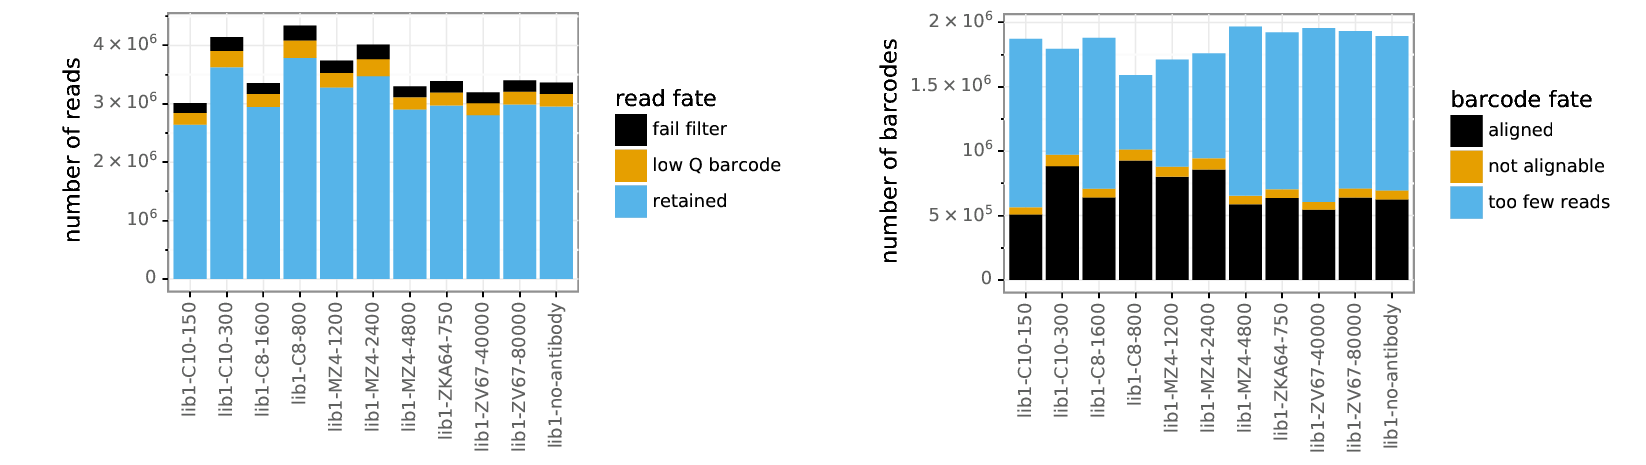

In [9]:
summary = codons_batch_subamp + "/summary_"

showPDF([os.path.join(summary + "readstats.pdf"),
         os.path.join(summary + "bcstats.pdf")])

LEFT, ABOVE: reads per sample. Per CK019 bottleneck calculations, we required ~4.5e6 per sample. This is below target as most samples are around 3e6 reads. We knew that 2 MiSeq flowcells might not be sufficient... this may be an indication of that. We can simply submit more prep for sequencing if we decide to. 

RIGHT, ABOVE: barcodes per sample. Target was 1.5e6 barcodes per sample. Aligned barcodes misses this target, with all samples falling in the 5e5-1e6 range. 

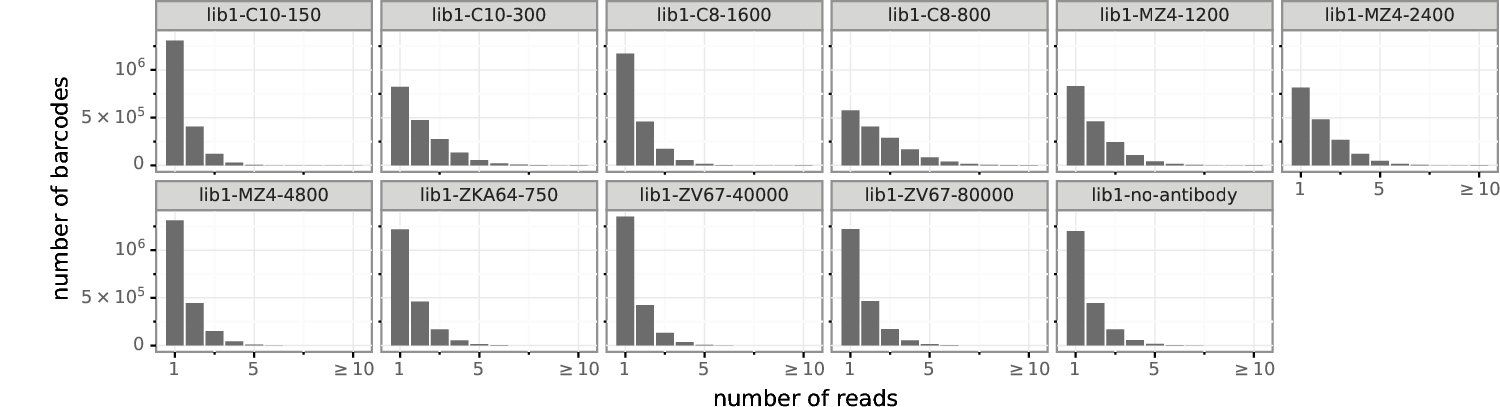

In [10]:
showPDF(os.path.join(summary + "readsperbc.pdf"))

ABOVE: reads per barcode. We need to read barcodes at least 2 times to error correct, but in many samples it looks like the majority of barcodes are being read once. This is likely due to insufficient sequencing depth.

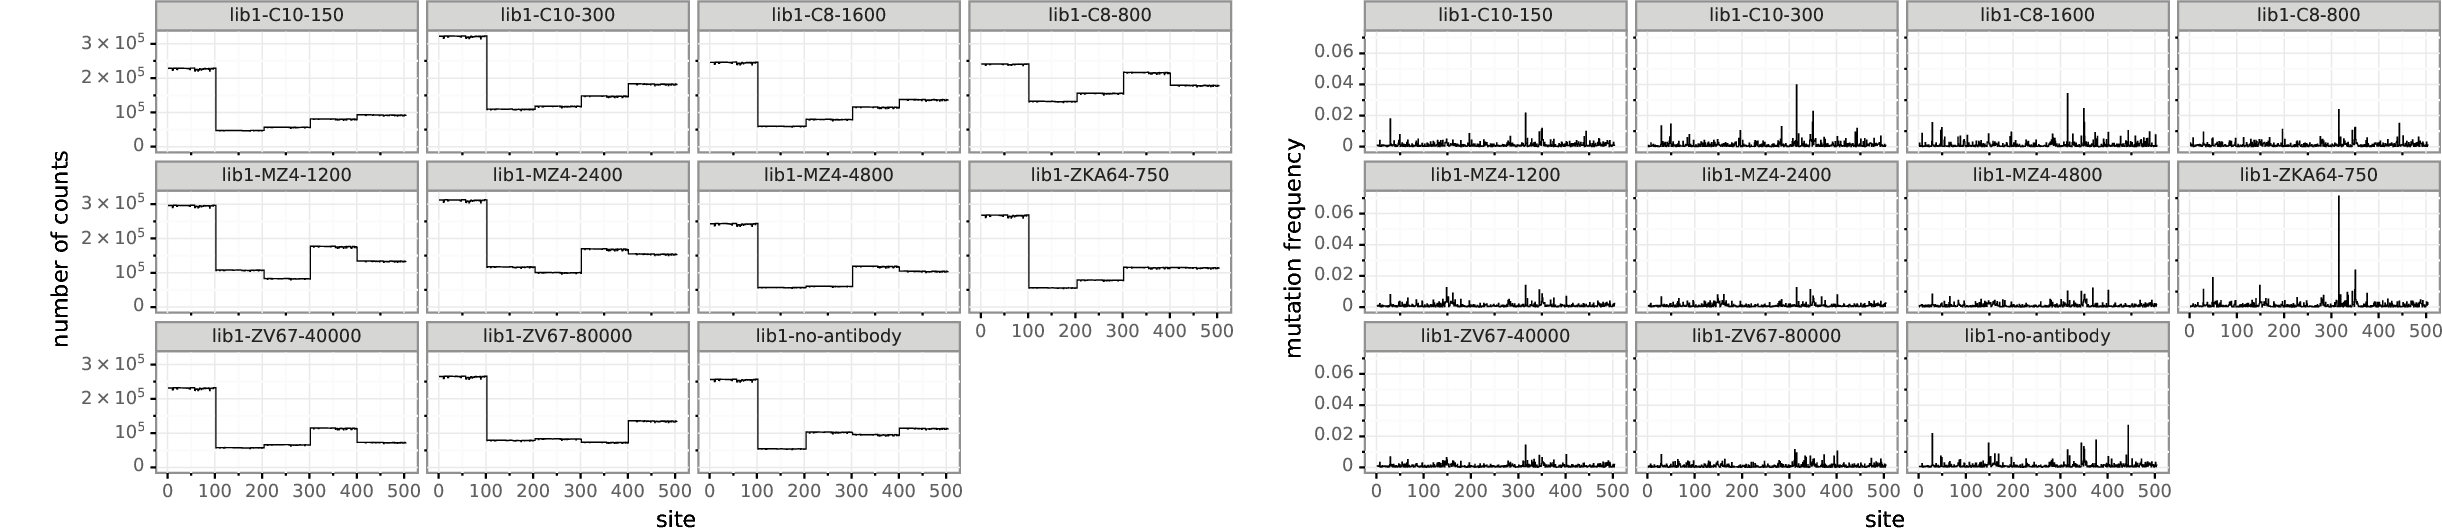

In [11]:
showPDF([os.path.join(summary + 'depth.pdf'),
         os.path.join(summary + 'mutfreq.pdf')])

LEFT, ABOVE: sequencing depth across 6 subamplicons. This looks quite uneven, especially compared to JBS083. Hopefully this resolves when we sequence more. 
RIGHT, ABOVE: mutation frequency across 6 subamplicons. Exciting to see probable selection taking place in some samples. 

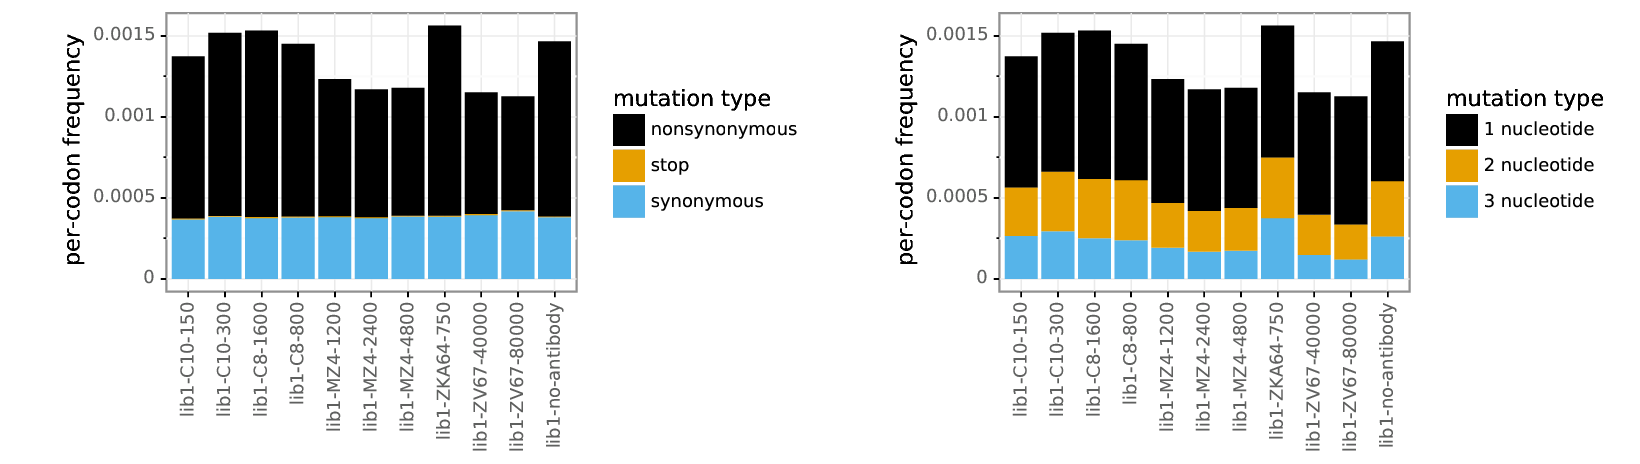

In [12]:
showPDF([os.path.join(summary + 'codonmuttypes.pdf'),
         os.path.join(summary + 'codonntchanges.pdf')])

LEFT, ABOVE: per-codon frequency of nonsynonymous, stop and synonymous mutations across samples. As expected, we see purging of stop codons in all my samples. 
RIGHT, ABOVE: per-codon frequency of 1-, 2-, or 3-nuc mutations across samples.

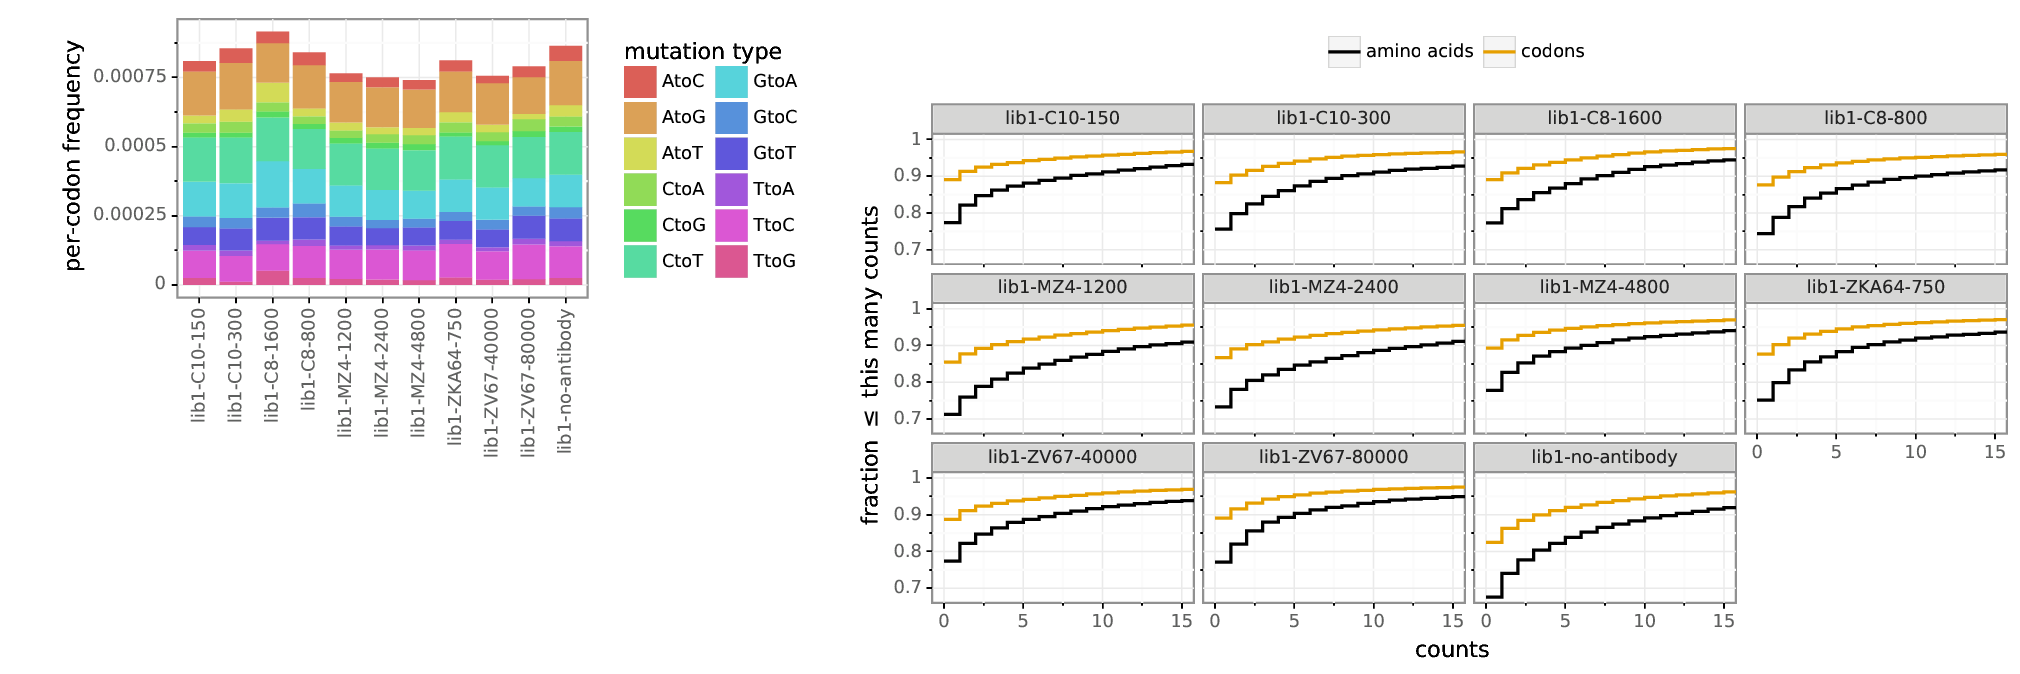

In [13]:
showPDF([os.path.join(summary + 'singlentchanges.pdf'),
         os.path.join(summary + 'cumulmutcounts.pdf')])

LEFT, ABOVE: per-codon frequency of various mutation types to evaluate for oxidative damage.
RIGHT, ABOVE: fraction of mutations that occurs a given #(count) of times. The no-ab (no antibody) control contains more diversity than the antibody- or serum-selected conditions.

# Differential selection

Next, I will use [dms2_batch_diffsel](https://jbloomlab.github.io/dms_tools2/dms2_batch_diffsel.html) to compute differential selection at each site along E protein in each sample. 

In [15]:
# make directory for grouped diffsel results
grouped_diffsel_dir = os.path.join(resultsdir + 'grouped_diffsel')
os.makedirs(grouped_diffsel_dir, exist_ok = True)

# make directory for individual concentrations diffsel results
diffsel_dir = os.path.join(resultsdir + 'diffsel')
os.makedirs(diffsel_dir, exist_ok = True)

In [16]:
# make batchfile for diffsel
# must contain selection column 'sel'
# must contain mock column 'mock'
# must contain error correction column 'err'

none_index = samples[(samples['antibody'] == 'none')].index
noAb_index = samples[(samples['antibody'] == 'no-antibody')].index

grouped_diffsel_batch = (
    samples
    .query('selection != "no-antibody"')
    .assign(sel = lambda x: x['name'],
            group = lambda x: x['antibody'],
            mock = lambda x: x['library'] + '-no-antibody')
    .drop(columns = ['R1', 'name'])
    .drop(none_index)
    .drop(noAb_index)
    .assign(name = lambda x: x['selection'])
    # .rename(columns = {'library' : 'name'})
    [['group', 'name', 'sel', 'mock', 'percent_infectivity']]
    .reset_index(drop = True)
    )
grouped_diffsel_batch

,group,name,sel,mock,percent_infectivity
0,EDE1-C10,C10-150,lib1-C10-150,lib1-no-antibody,0.51%
1,EDE1-C10,C10-300,lib1-C10-300,lib1-no-antibody,0.11%
2,EDE1-C8,C8-1600,lib1-C8-1600,lib1-no-antibody,0.01%
3,EDE1-C8,C8-800,lib1-C8-800,lib1-no-antibody,0.57%
4,MZ4,MZ4-1200,lib1-MZ4-1200,lib1-no-antibody,5.22%
5,MZ4,MZ4-2400,lib1-MZ4-2400,lib1-no-antibody,0.98%
6,MZ4,MZ4-4800,lib1-MZ4-4800,lib1-no-antibody,0.46%
7,ZKA-64,ZKA64-750,lib1-ZKA64-750,lib1-no-antibody,0.57%
8,ZV-67,ZV67-40000,lib1-ZV67-40000,lib1-no-antibody,0.84%
9,ZV-67,ZV67-80000,lib1-ZV67-80000,lib1-no-antibody,0.26%


In [17]:
# make batchfile for diffsel
# must contain selection column 'sel'
# must contain mock column 'mock'
# must contain error correction column 'err'

none_index = samples[(samples['antibody'] == 'none')].index
noAb_index = samples[(samples['antibody'] == 'no-antibody')].index

diffsel_batch = (
    samples
    .query('selection != "no-antibody"')
    .assign(sel = lambda x: x['name'],
            # group = lambda x: x['antibody'],
            mock = lambda x: x['library'] + '-no-antibody')
    .drop(columns = ['R1', 'name'])
    .drop(none_index)
    .drop(noAb_index)
    .assign(name = lambda x: x['selection'])
    # .rename(columns = {'library' : 'name'})
    [['name', 'sel', 'mock', 'percent_infectivity']]
    .reset_index(drop = True)
    )
diffsel_batch

,name,sel,mock,percent_infectivity
0,C10-150,lib1-C10-150,lib1-no-antibody,0.51%
1,C10-300,lib1-C10-300,lib1-no-antibody,0.11%
2,C8-1600,lib1-C8-1600,lib1-no-antibody,0.01%
3,C8-800,lib1-C8-800,lib1-no-antibody,0.57%
4,MZ4-1200,lib1-MZ4-1200,lib1-no-antibody,5.22%
5,MZ4-2400,lib1-MZ4-2400,lib1-no-antibody,0.98%
6,MZ4-4800,lib1-MZ4-4800,lib1-no-antibody,0.46%
7,ZKA64-750,lib1-ZKA64-750,lib1-no-antibody,0.57%
8,ZV67-40000,lib1-ZV67-40000,lib1-no-antibody,0.84%
9,ZV67-80000,lib1-ZV67-80000,lib1-no-antibody,0.26%


In [18]:
# write grouped diffsel batchfile to csv
grouped_diffsel_batchfile = os.path.join(grouped_diffsel_dir + '/batch.csv')
grouped_diffsel_batch.to_csv(grouped_diffsel_batchfile, index = False)

# run dms2_batch_diffsel for grouped batchfile
baka = ! dms2_batch_diffsel \
        --batchfile {grouped_diffsel_batchfile} \
        --summaryprefix summary \
        --indir {codons_batch_subamp} \
        --outdir {grouped_diffsel_dir} \
        --ncpus 16 \
        --use_existing {use_existing}

In [19]:
# write individual concentration diffsel batchfile to csv
diffsel_batchfile = os.path.join(diffsel_dir + '/batch.csv')
diffsel_batch.to_csv(diffsel_batchfile, index = False)

# run dms2_batch_diffsel for individual concentration batchfile
baka = ! dms2_batch_diffsel \
        --batchfile {diffsel_batchfile} \
        --summaryprefix summary \
        --indir {codons_batch_subamp} \
        --outdir {diffsel_dir} \
        --ncpus 16 \
        --use_existing {use_existing}

## Calculating correlation between pseudo-technical replicates
We can consider antibodies tested at mutiple concentraitons as pseudo-technical replicates and see how well they correlate. If these pseudo-technical replicates do correlate, we could combine data and calcualte differential selection that way. 


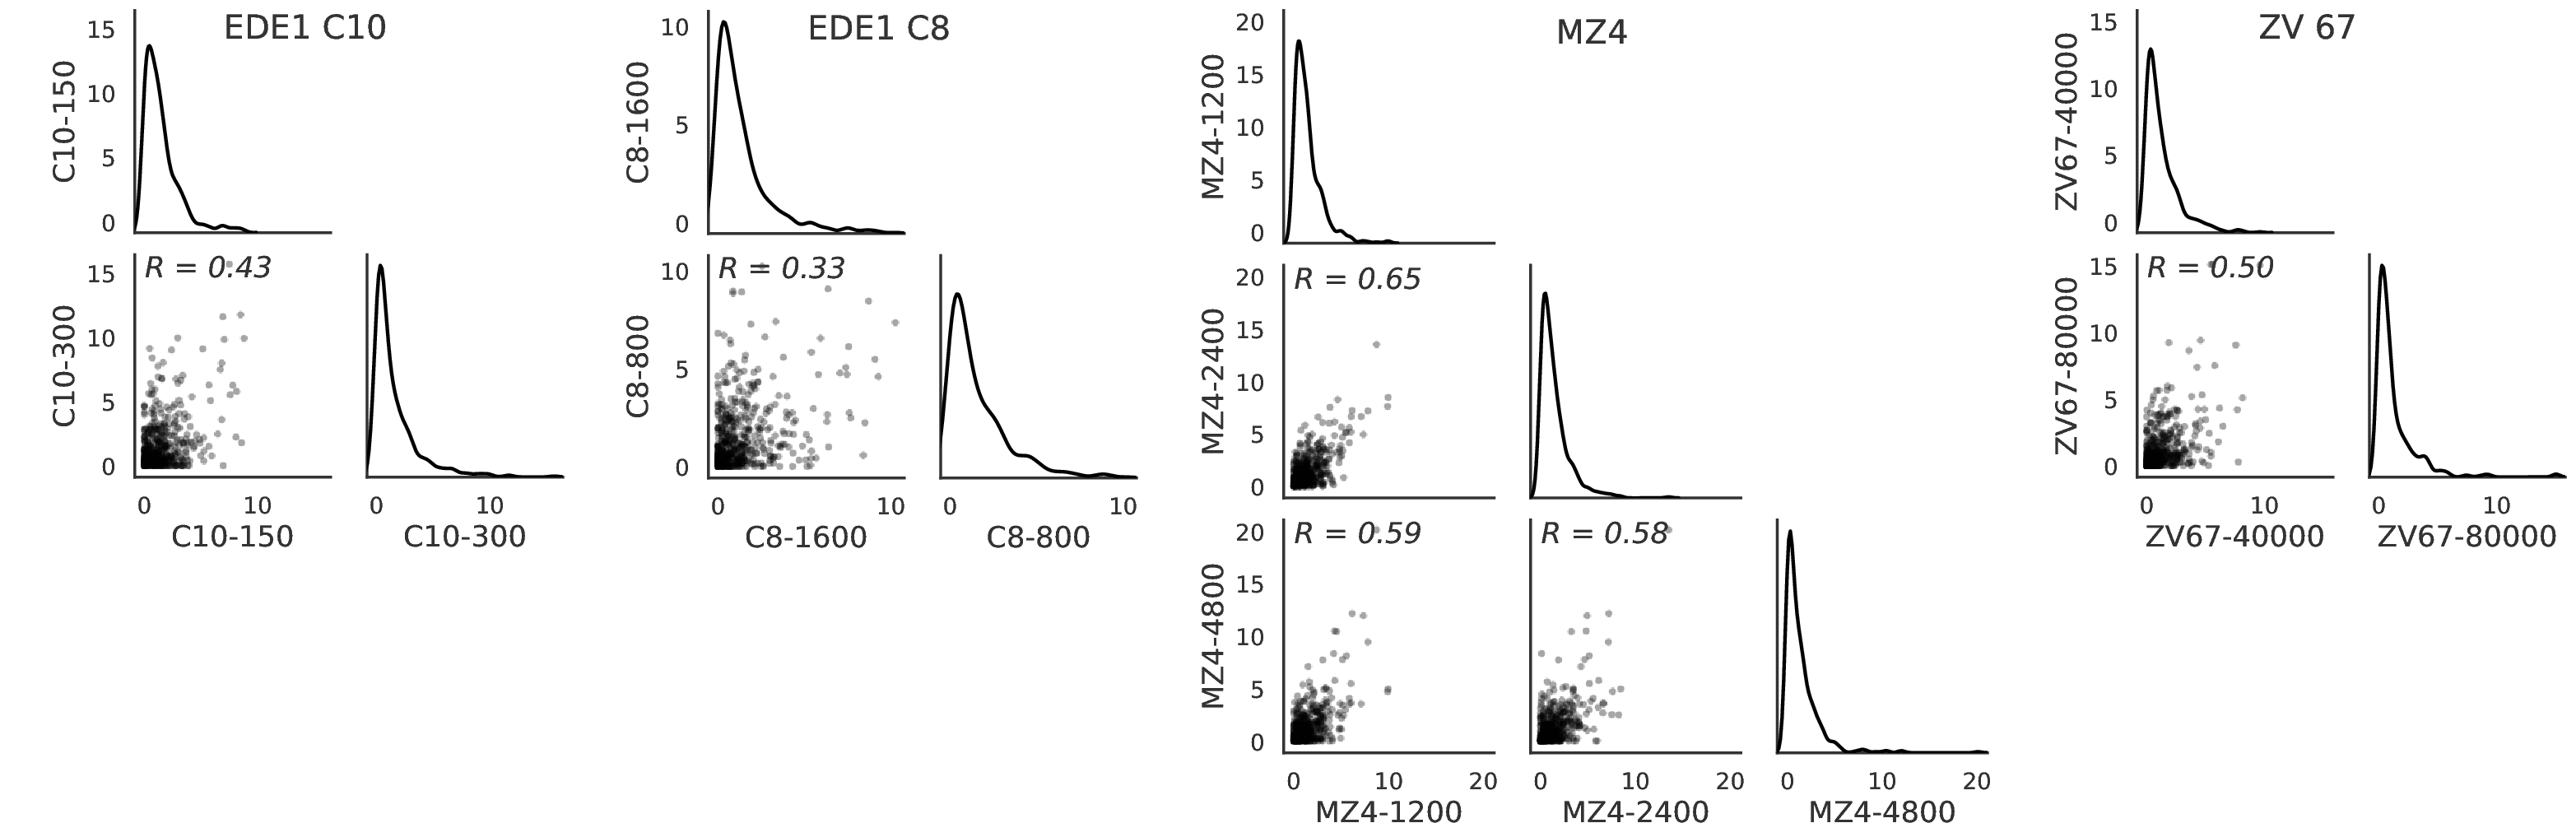

In [20]:
showPDF([os.path.join(grouped_diffsel_dir, f'summary_{antibody}-positivesitediffselcorr.pdf')
         for antibody in grouped_diffsel_batch.query('group != "ZKA-64"').group.unique()])

These plots show that the strongest pseudo-technical replicate selections occured with MZ4 and ZV-67. EDE1-C10 is less convincing and the EDE1-C8 mostly ressembles scattershot.

I will try combining all datasets and display those data as logoplots below. 

## Mean differential selection displayed as logoplots
Using [dms2_logoplot](https://jbloomlab.github.io/dms_tools2/dms2_logoplot.html), we can create logoplots of the results of the mean differential selection data. 

In [21]:
# make directory for grouped diffsel logoplots
grouped_logo_dir = os.path.join(resultsdir + 'grouped_logoplots/')
os.makedirs(grouped_logo_dir, exist_ok = True)

# make directory for individual concentration diffsel logoplots
logo_dir = os.path.join(resultsdir + 'logoplots/')
os.makedirs(logo_dir, exist_ok = True)

In [22]:
# for each antibody group in diffsel, run dms2_logoplot
for ab in grouped_diffsel_batch.query('group != "control-antibody"').group.unique():
    diffselfile = os.path.join(grouped_diffsel_dir, f'summary_{ab}-meanmutdiffsel.csv')
    baka = ! dms2_logoplot \
        --outdir {grouped_logo_dir} \
        --ncpus 16 \
        --name {ab} \
        --diffsel {diffselfile} \
        --restrictdiffsel positive \
        --nperline 101 \
        --scalebar 10 "diffsel = 10" \
        --underlay yes \
        --use_existing {use_existing}
# Jesse's overlay of WT seq is generated during the funcational selection analysis - at some point I will need to go back and do this

logoplot for EDE1-C10 shown below, saved to ./results/grouped_logoplots/EDE1-C10_diffsel.pdf


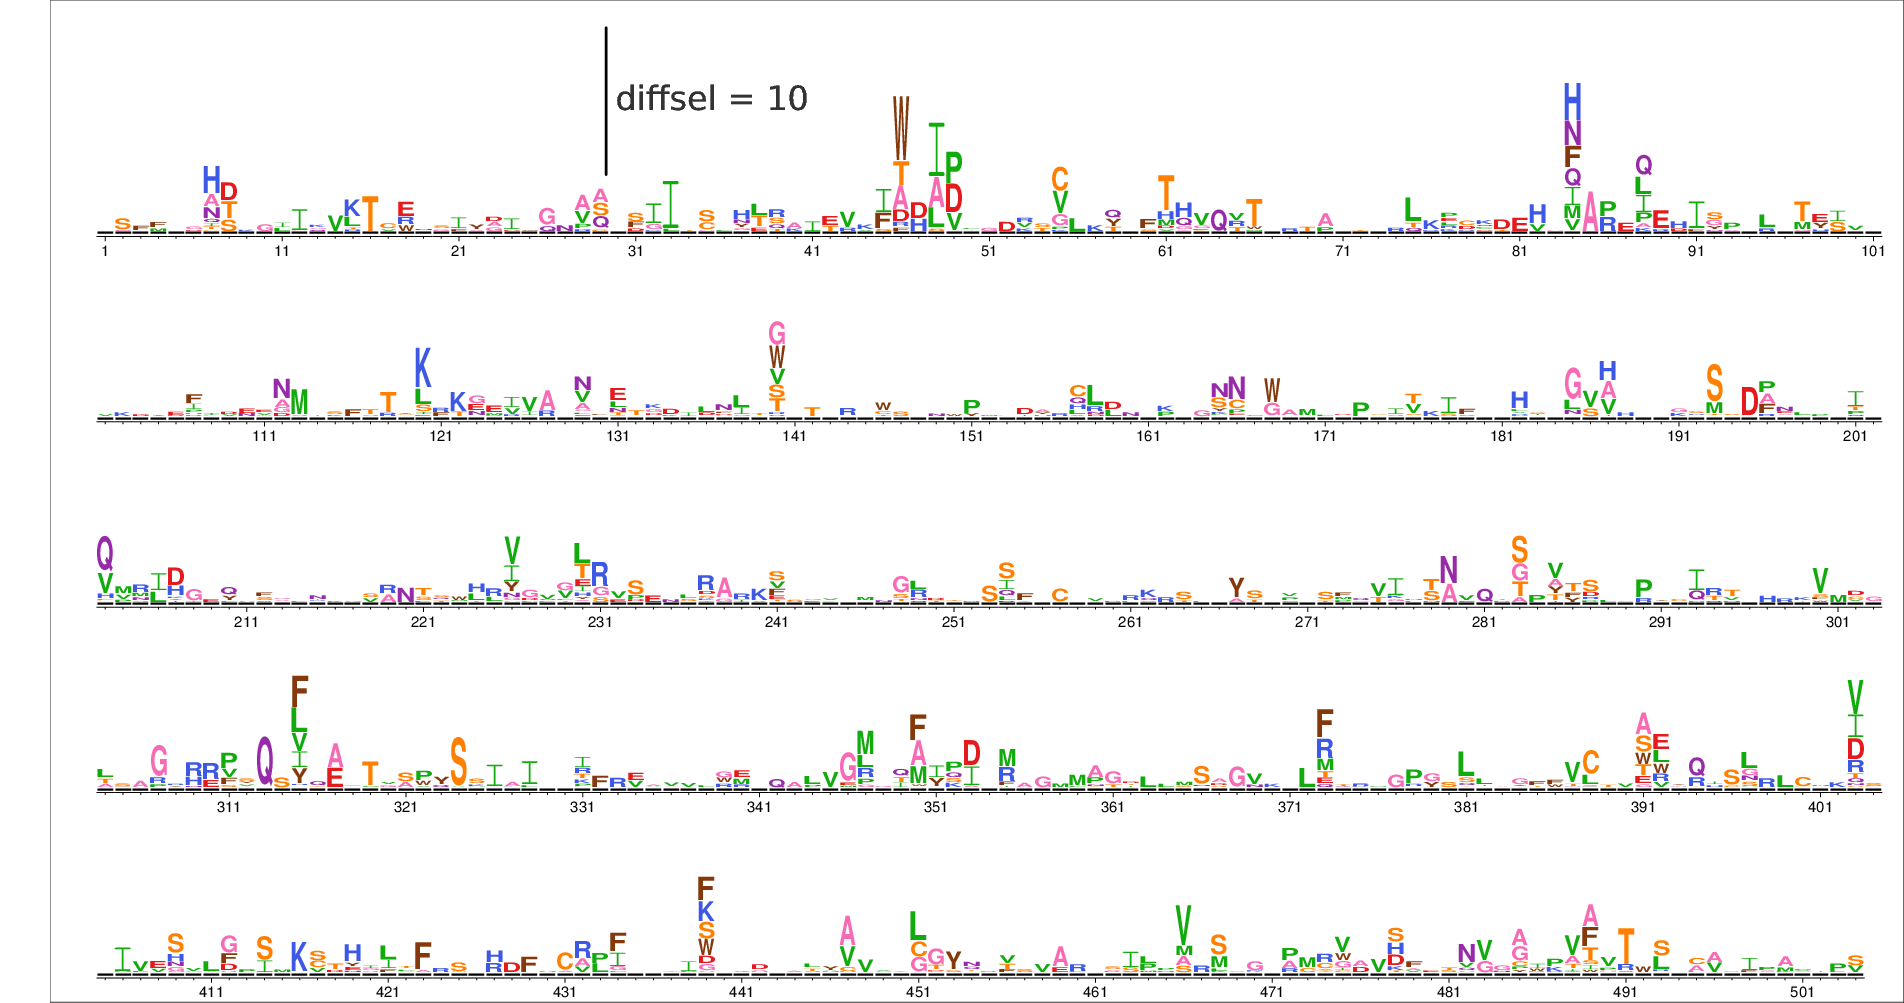

logoplot for EDE1-C8 shown below, saved to ./results/grouped_logoplots/EDE1-C8_diffsel.pdf


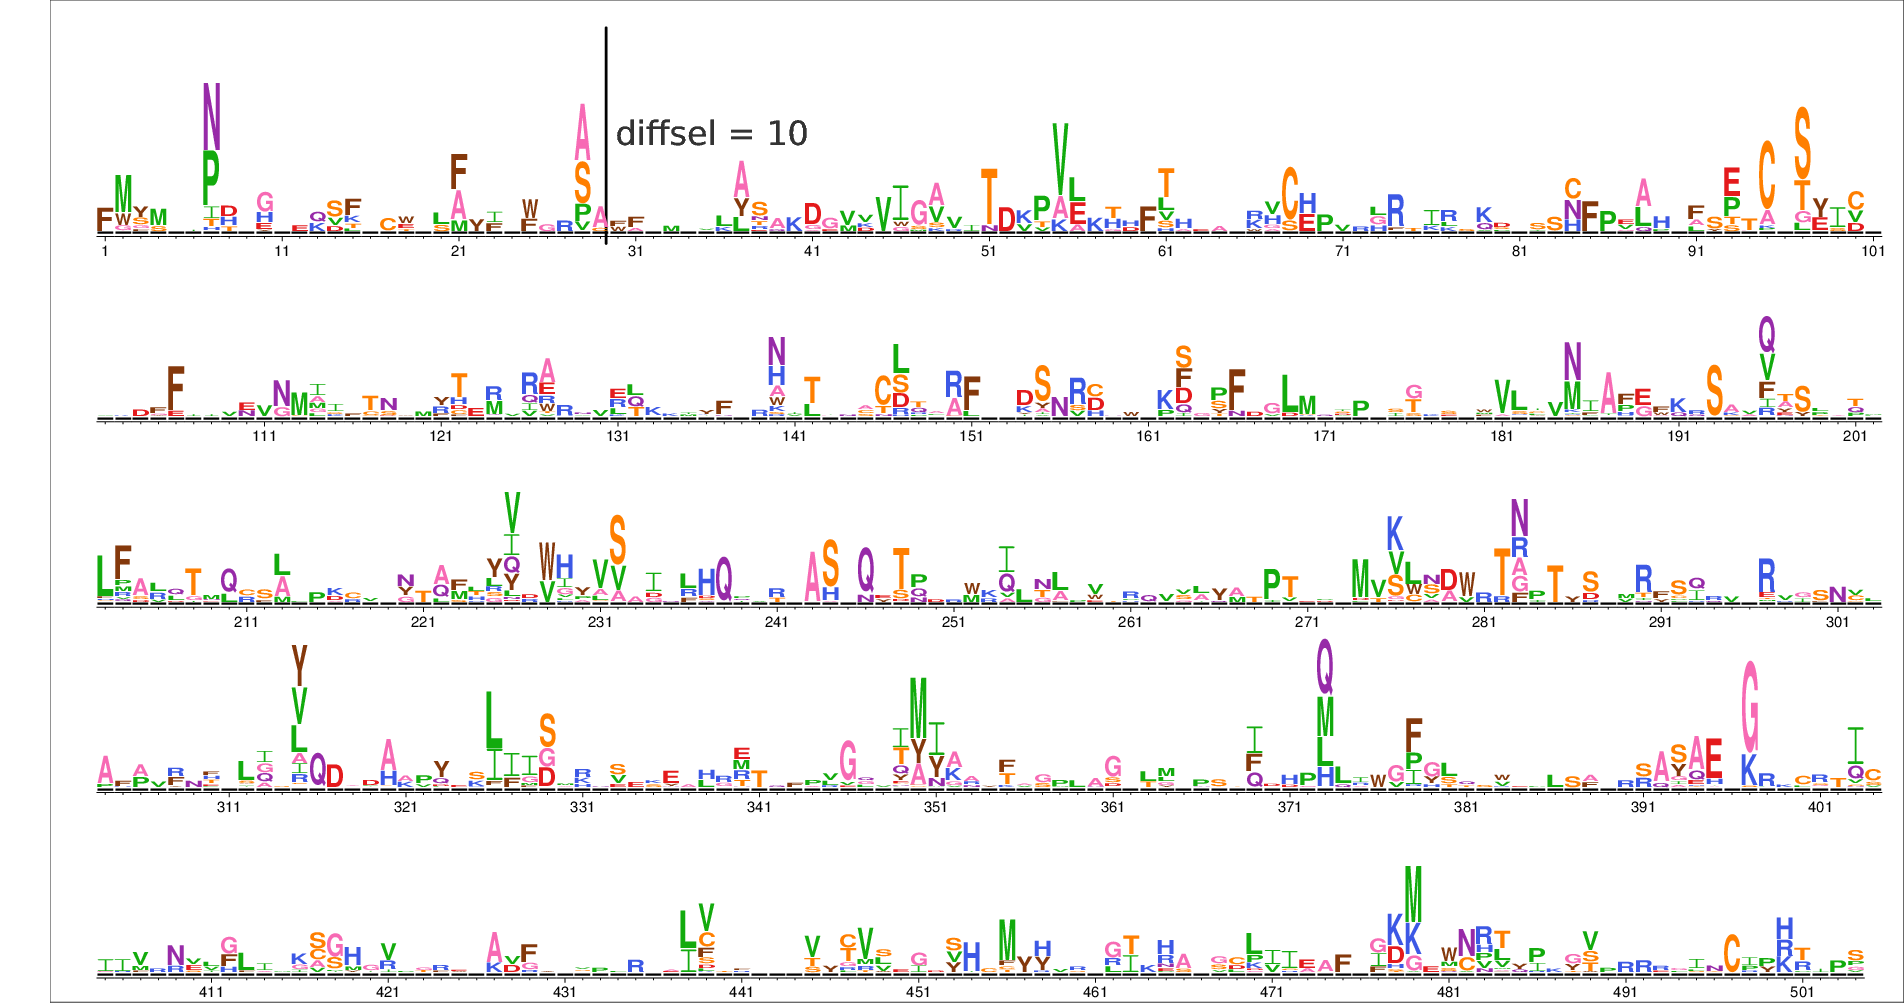

logoplot for MZ4 shown below, saved to ./results/grouped_logoplots/MZ4_diffsel.pdf


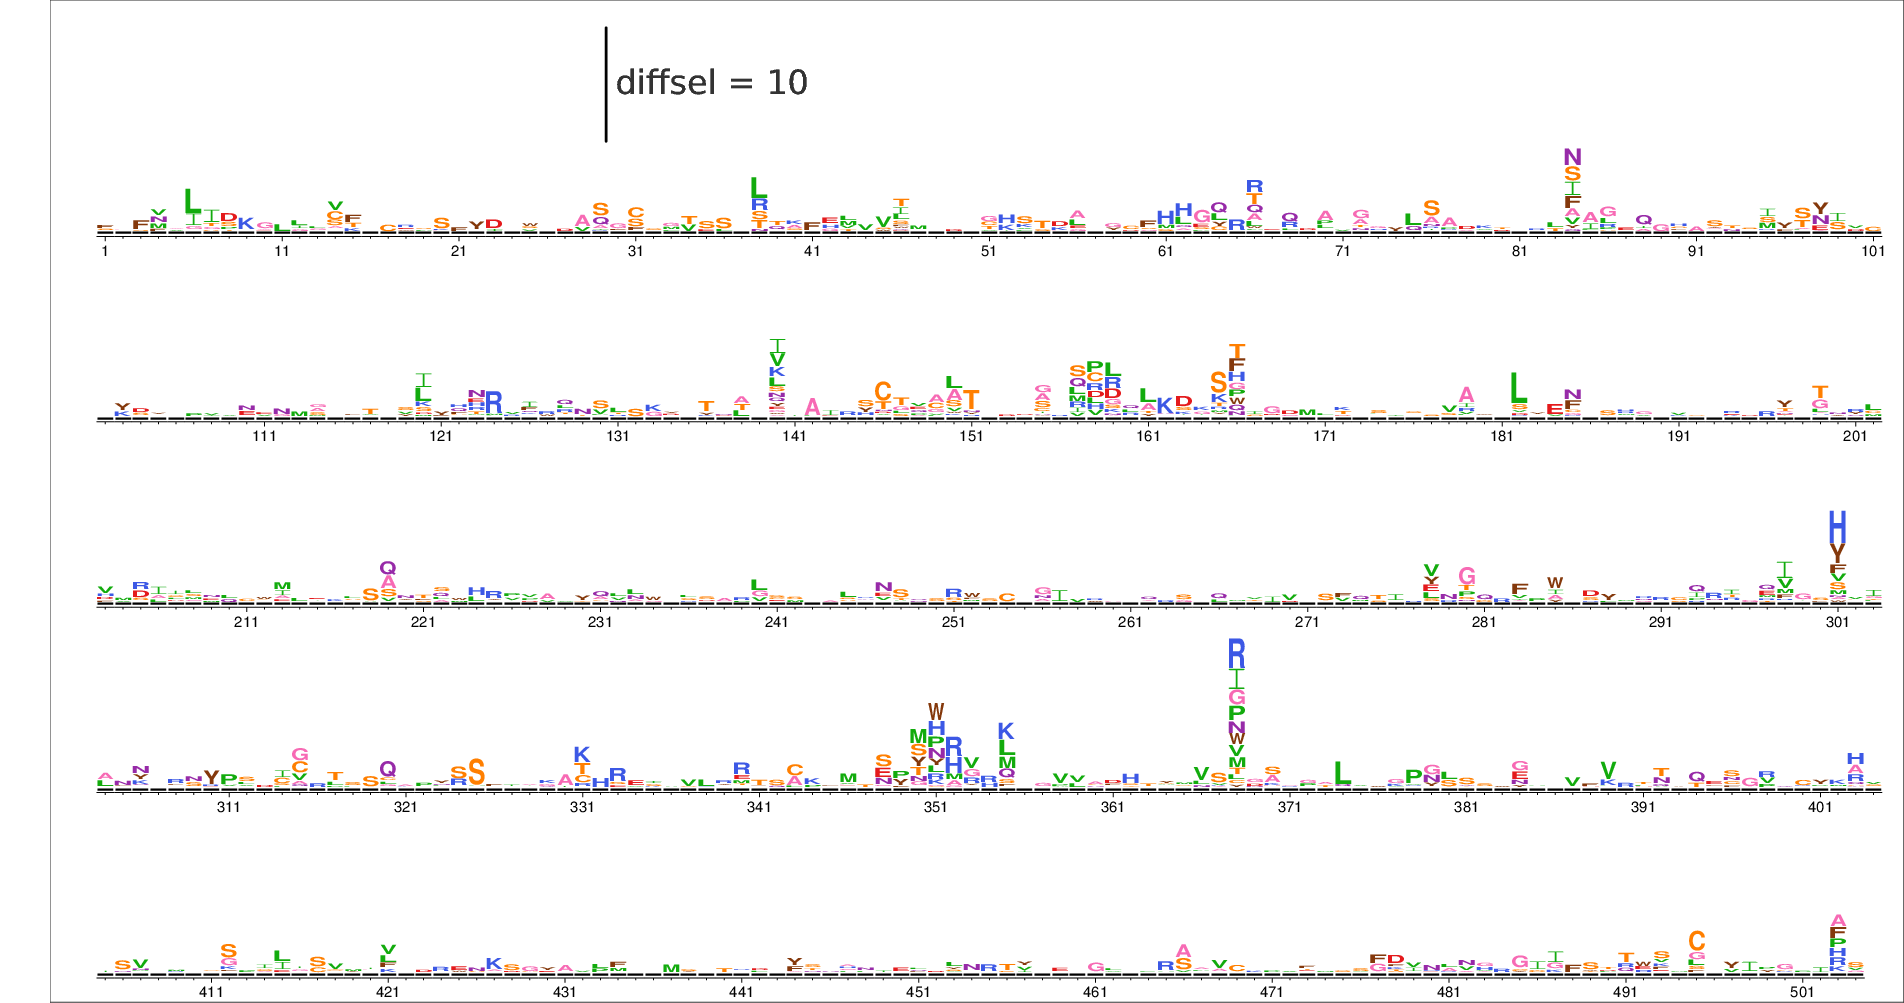

logoplot for ZKA-64 shown below, saved to ./results/grouped_logoplots/ZKA-64_diffsel.pdf


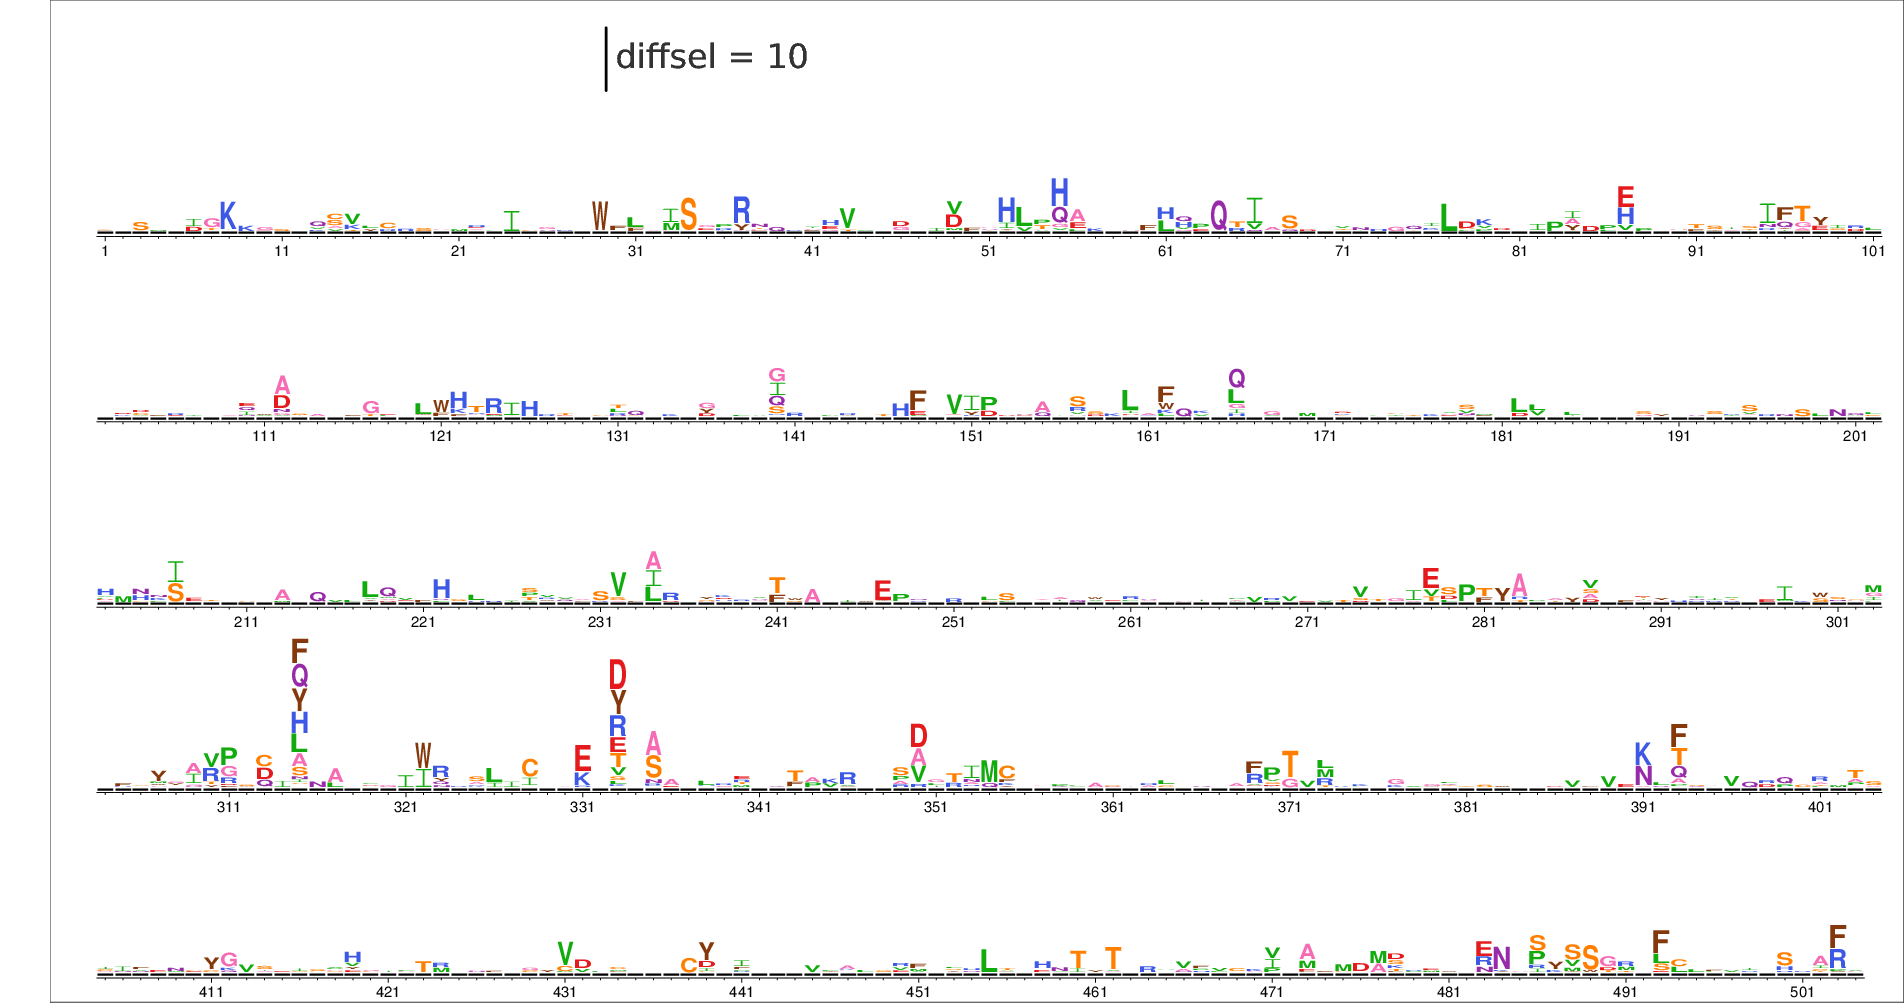

logoplot for ZV-67 shown below, saved to ./results/grouped_logoplots/ZV-67_diffsel.pdf


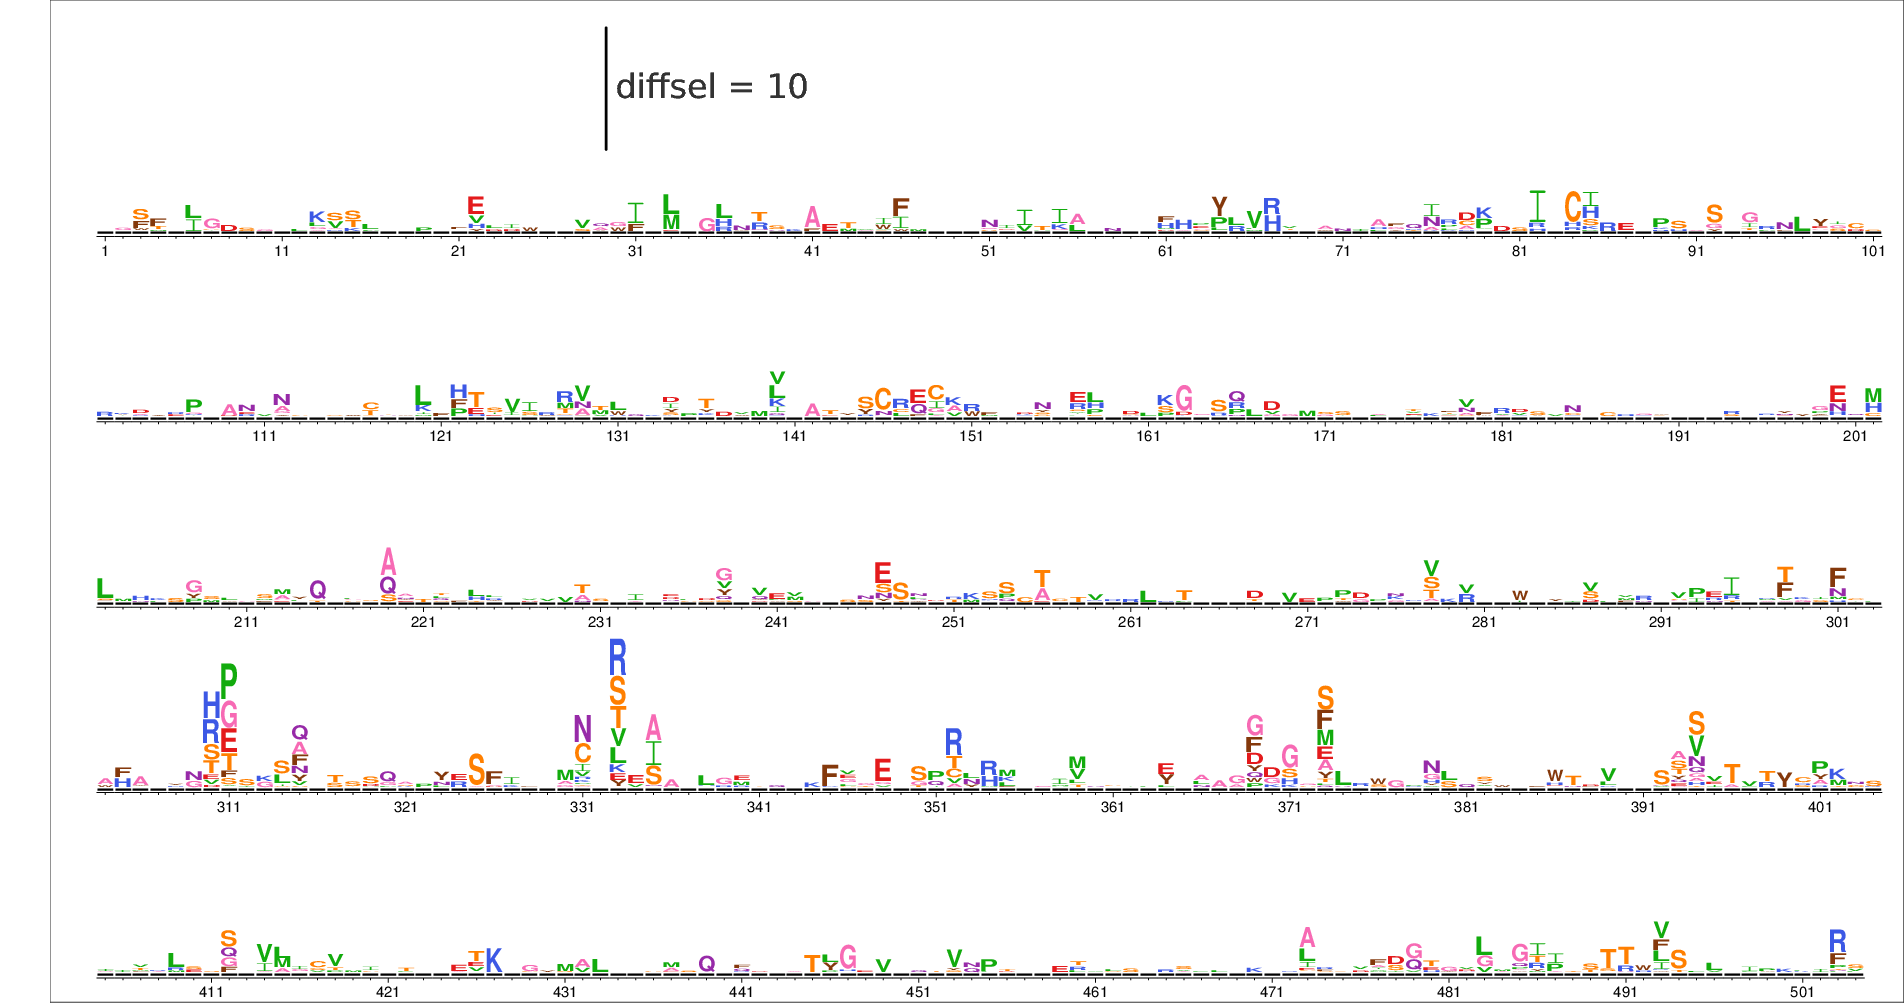

In [23]:
# show logoplot results by antibody 'group'
for sample in grouped_diffsel_batch['group'].unique():
    print(f'logoplot for {sample} shown below, saved to ' + os.path.join(grouped_logo_dir, sample + '_diffsel.pdf'))
    showPDF(os.path.join(grouped_logo_dir, sample + '_diffsel.pdf'))

In [38]:
# for each antibody and each concentration in diffsel, run dms2_logoplot
for ab in diffsel_batch.name.unique():
    diffselfile = os.path.join(diffsel_dir, f'{ab}_mutdiffsel.csv')
    baka = ! dms2_logoplot \
        --outdir {logo_dir} \
        --ncpus 16 \
        --name {ab} \
        --diffsel {diffselfile} \
        --restrictdiffsel positive \
        --nperline 101 \
        --scalebar 10 "diffsel = 10" \
        --underlay yes \
        --use_existing {use_existing}
# Jesse's overlay of WT seq is generated during the funcational selection analysis - at some point I will need to go back and do this

logoplot for C10-150 shown below, saved to ./results/logoplots/C10-150_diffsel.pdf


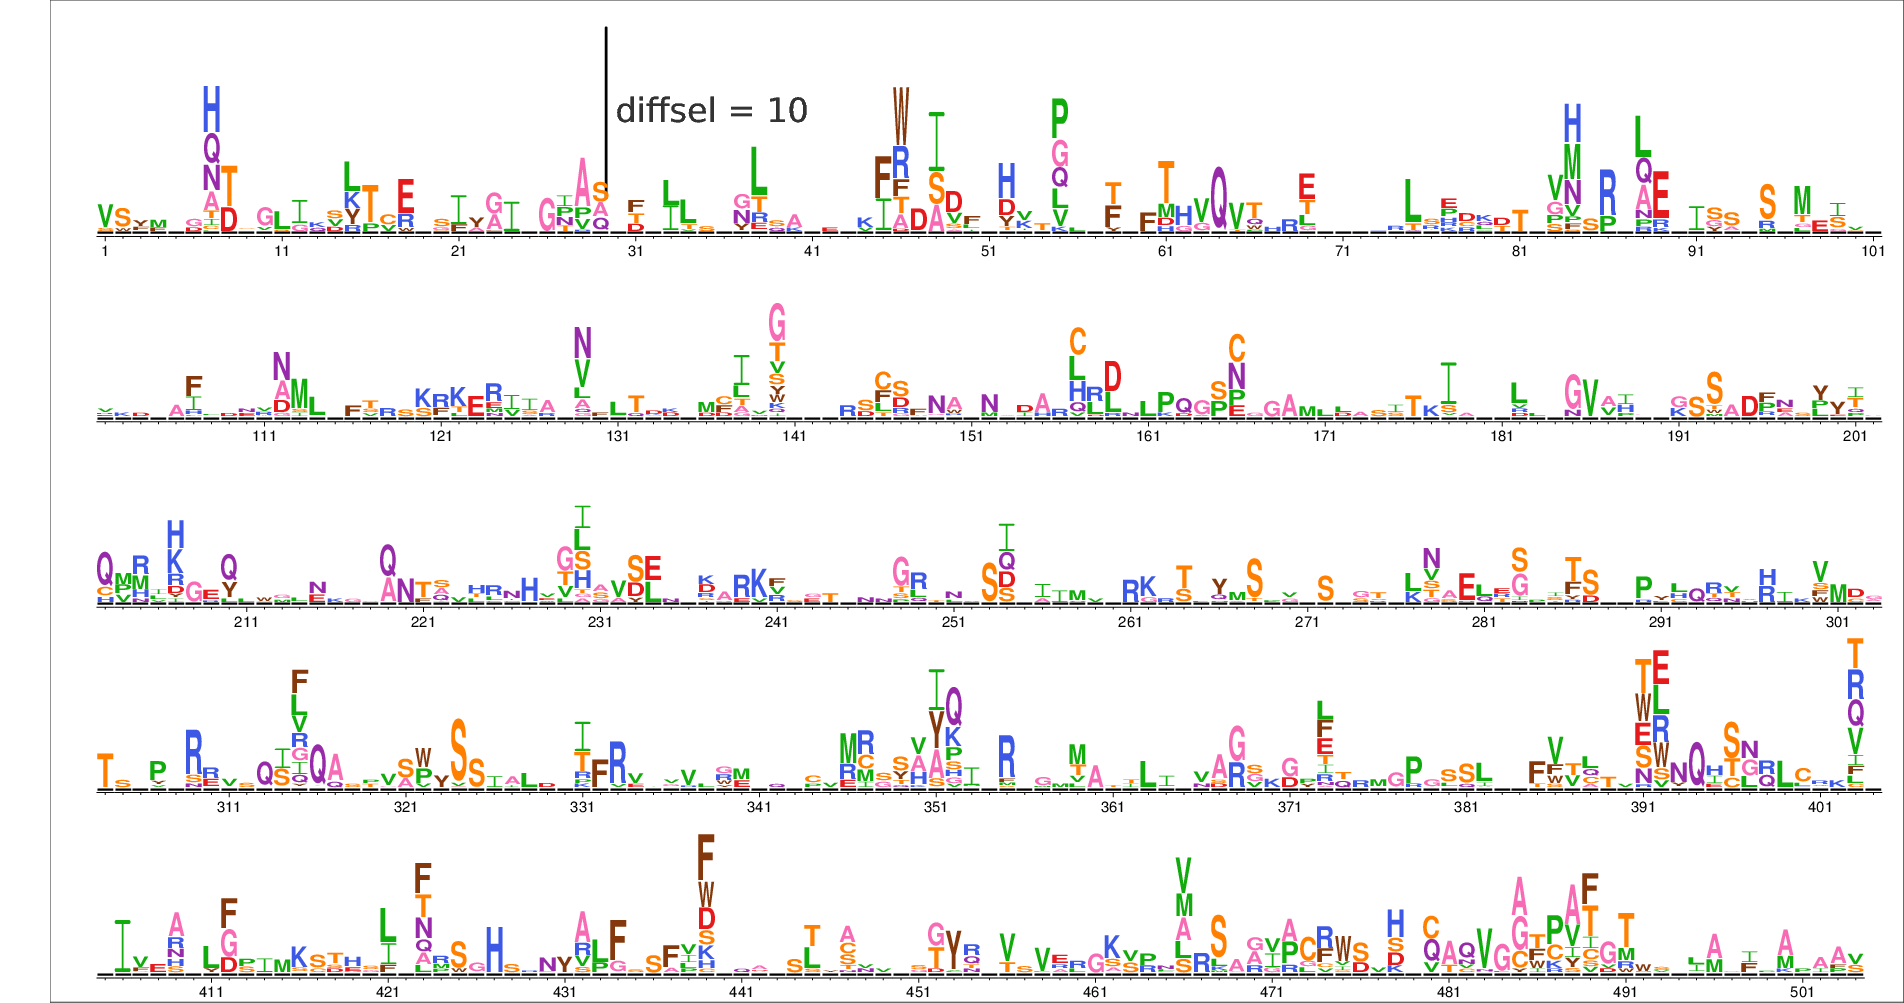

logoplot for C10-300 shown below, saved to ./results/logoplots/C10-300_diffsel.pdf


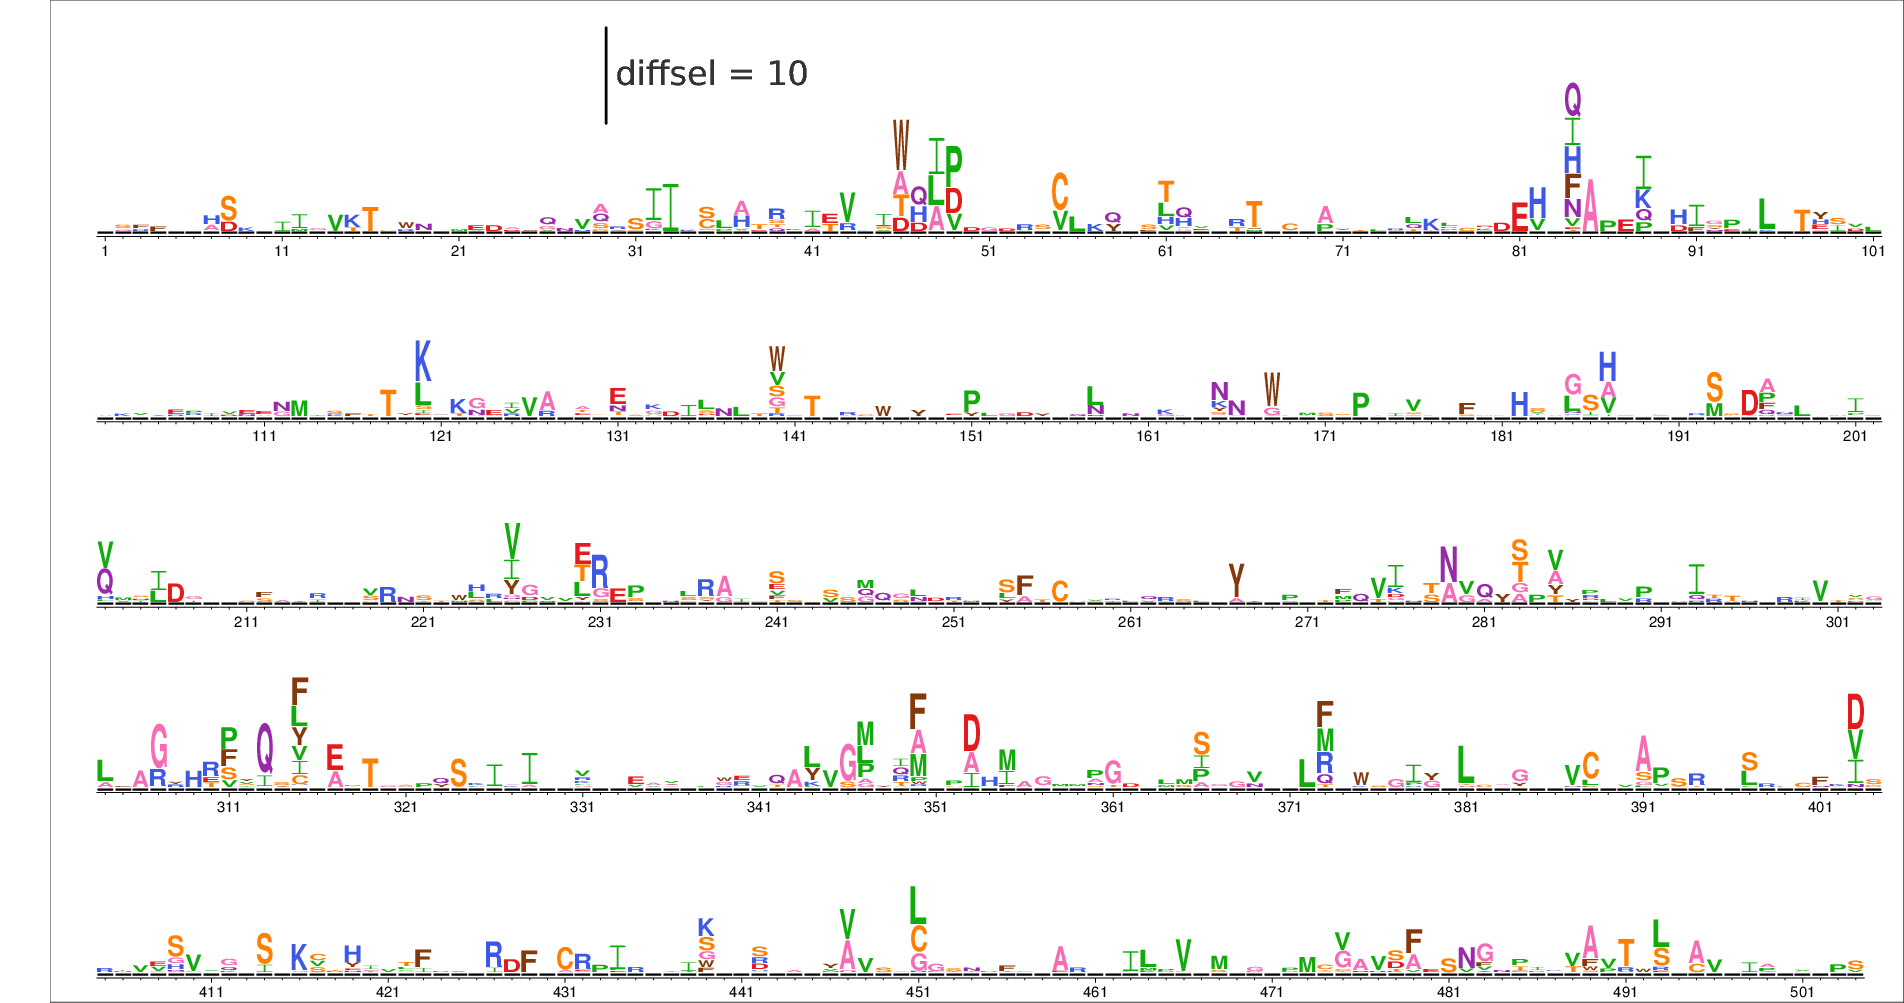

logoplot for C8-1600 shown below, saved to ./results/logoplots/C8-1600_diffsel.pdf


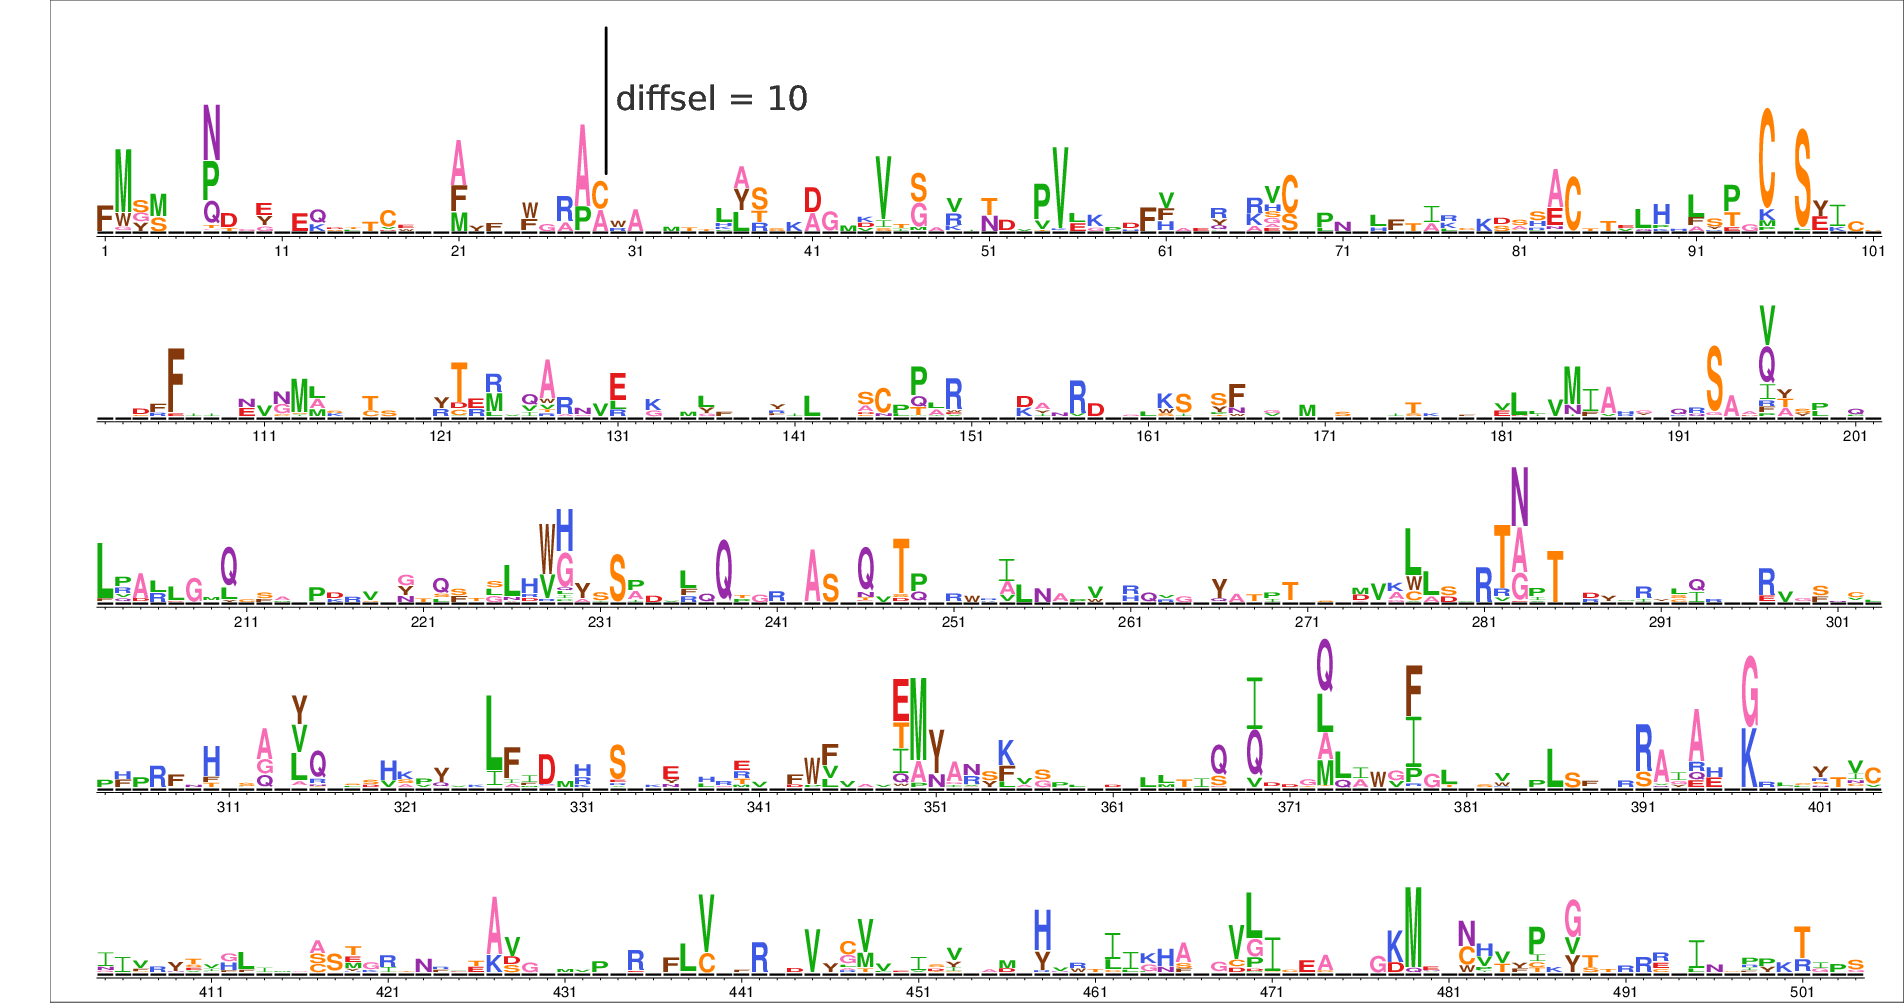

logoplot for C8-800 shown below, saved to ./results/logoplots/C8-800_diffsel.pdf


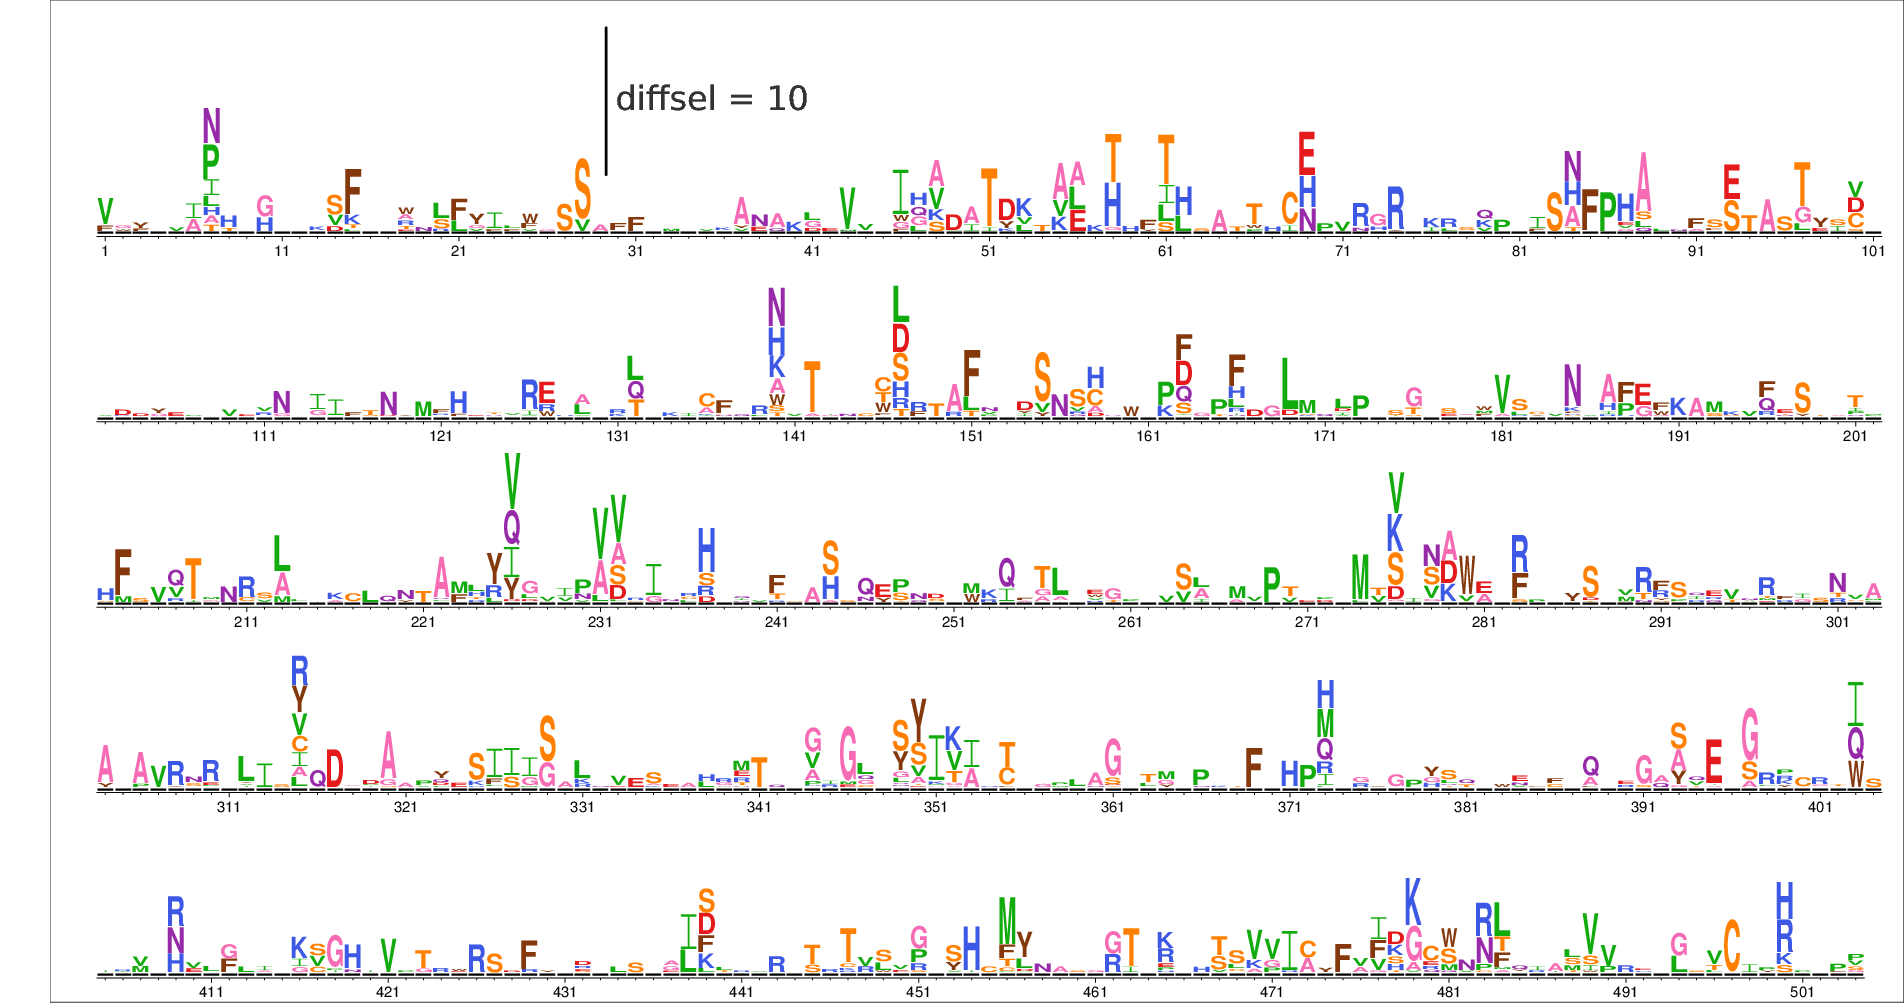

logoplot for MZ4-1200 shown below, saved to ./results/logoplots/MZ4-1200_diffsel.pdf


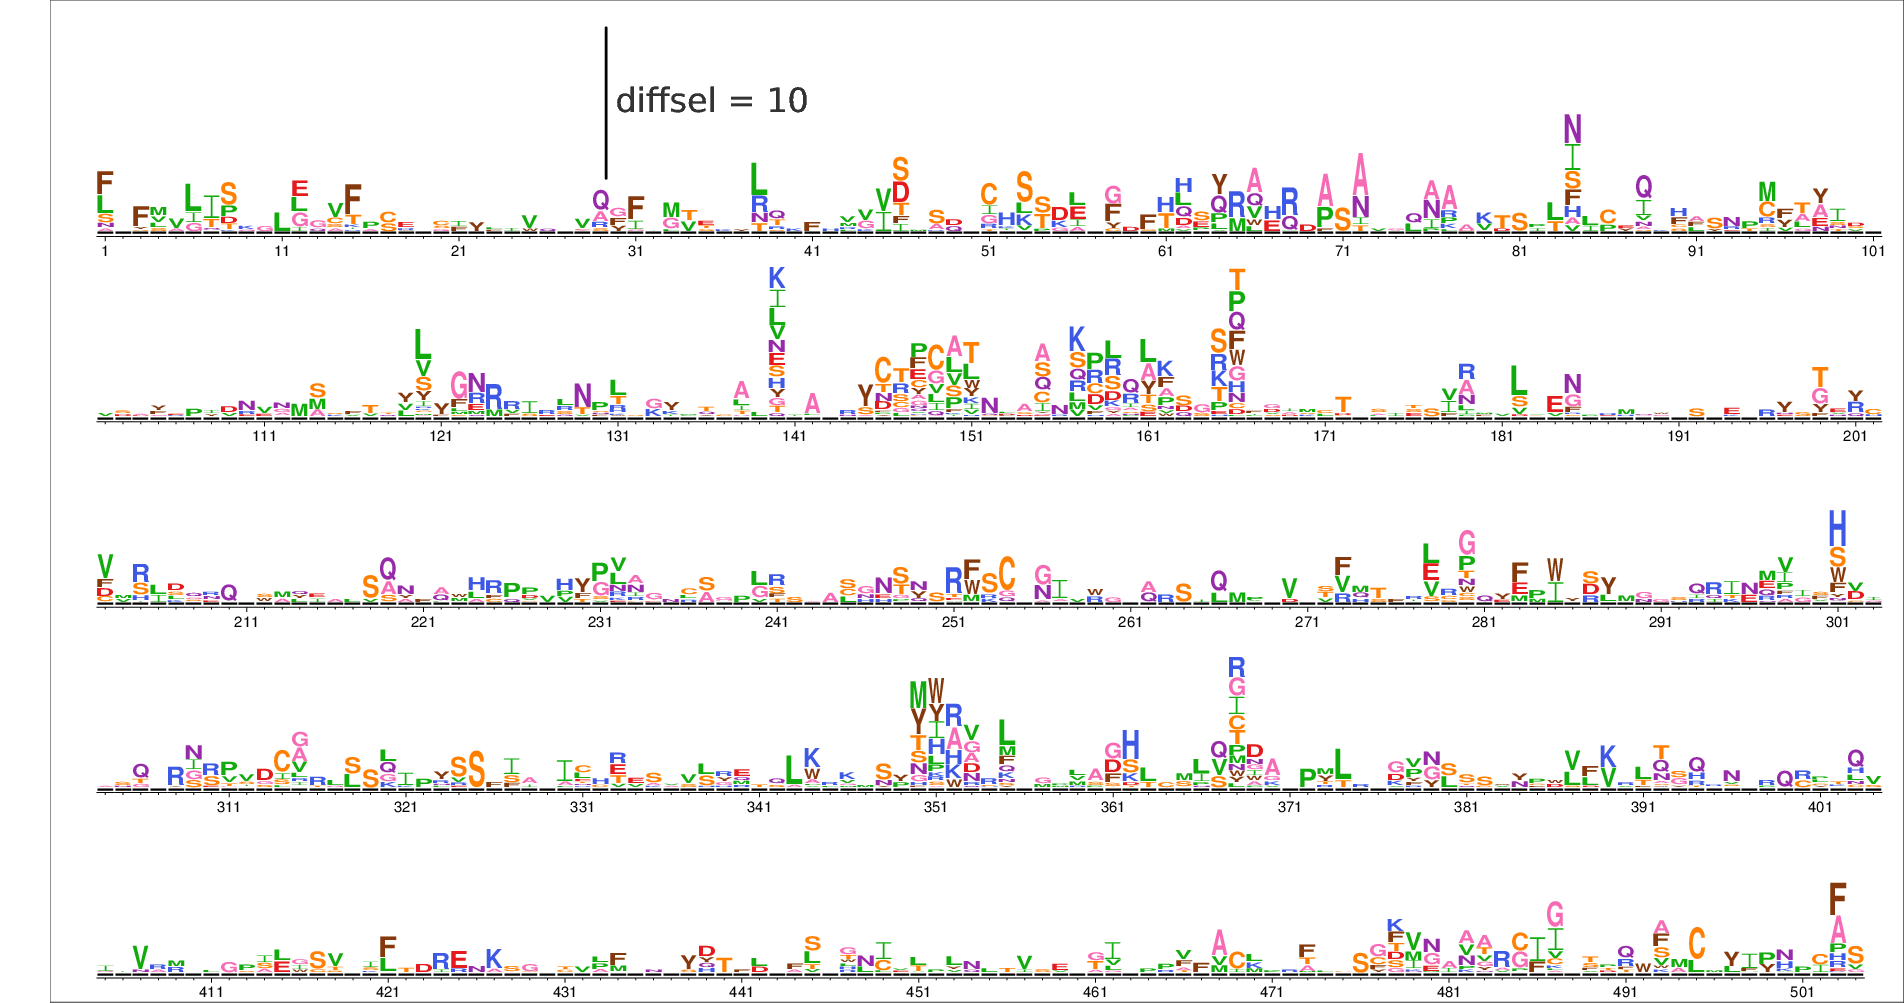

logoplot for MZ4-2400 shown below, saved to ./results/logoplots/MZ4-2400_diffsel.pdf


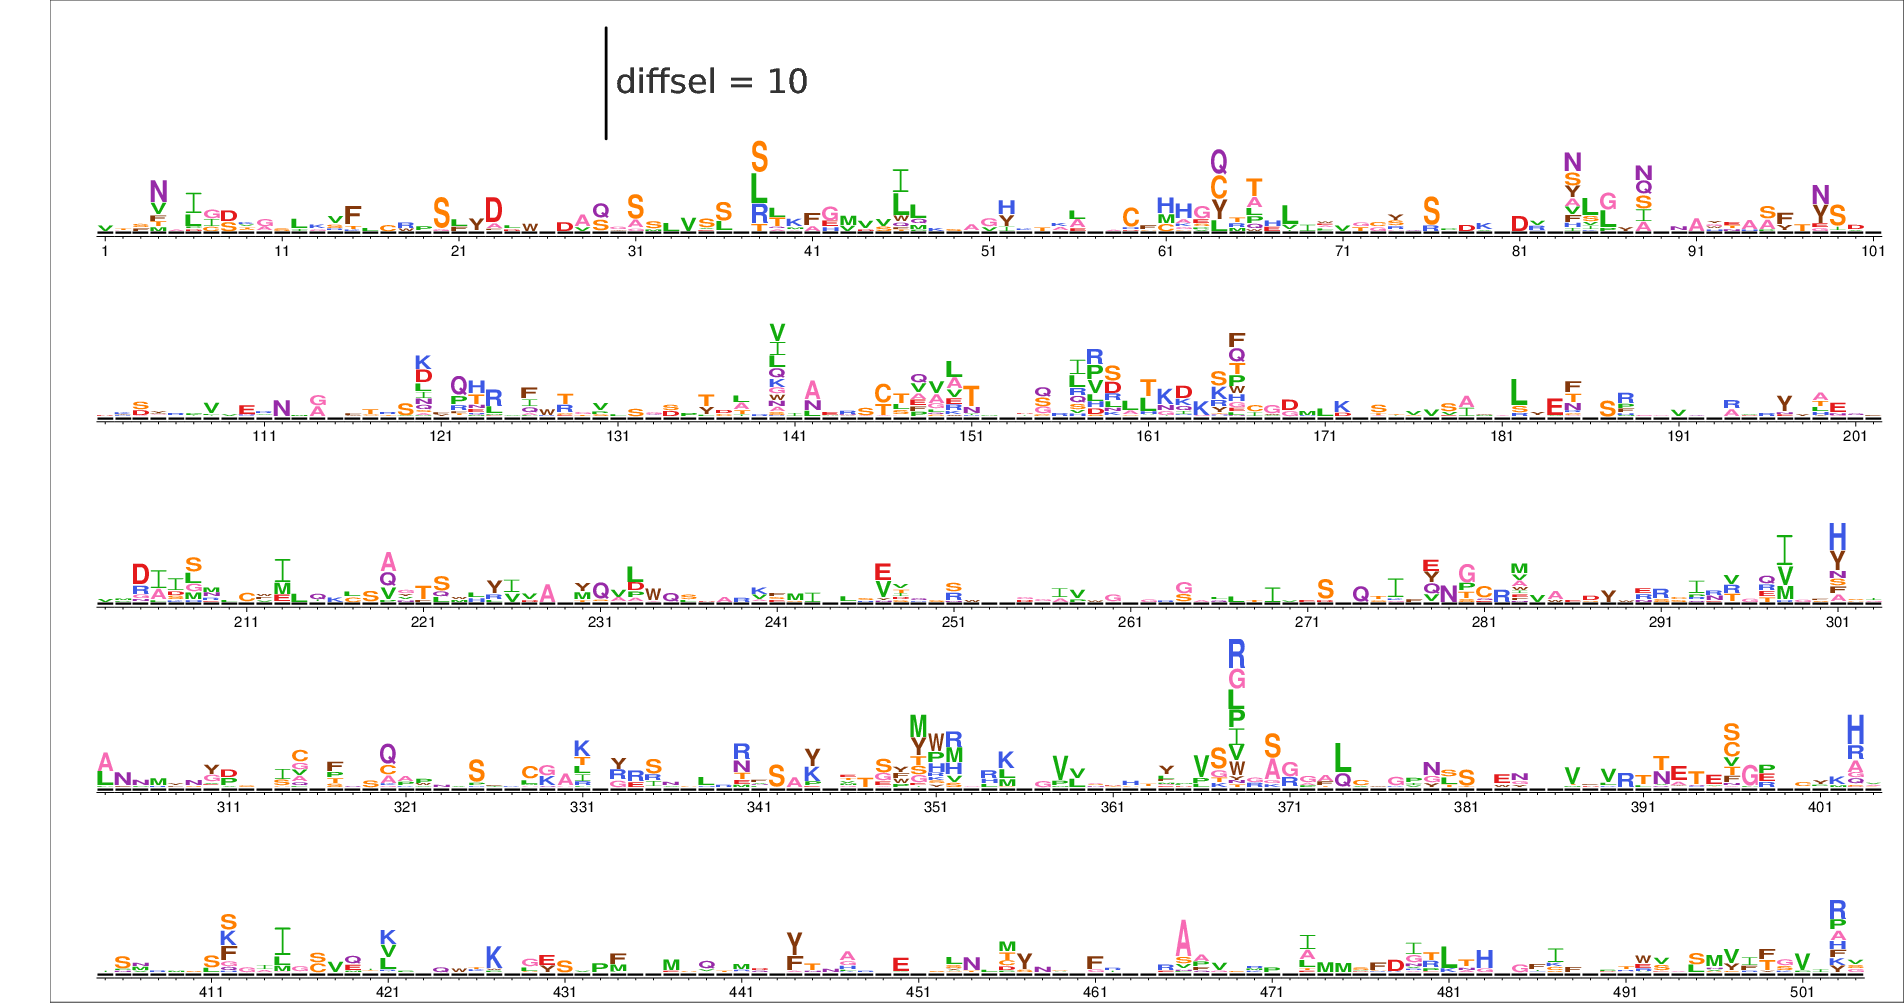

logoplot for MZ4-4800 shown below, saved to ./results/logoplots/MZ4-4800_diffsel.pdf


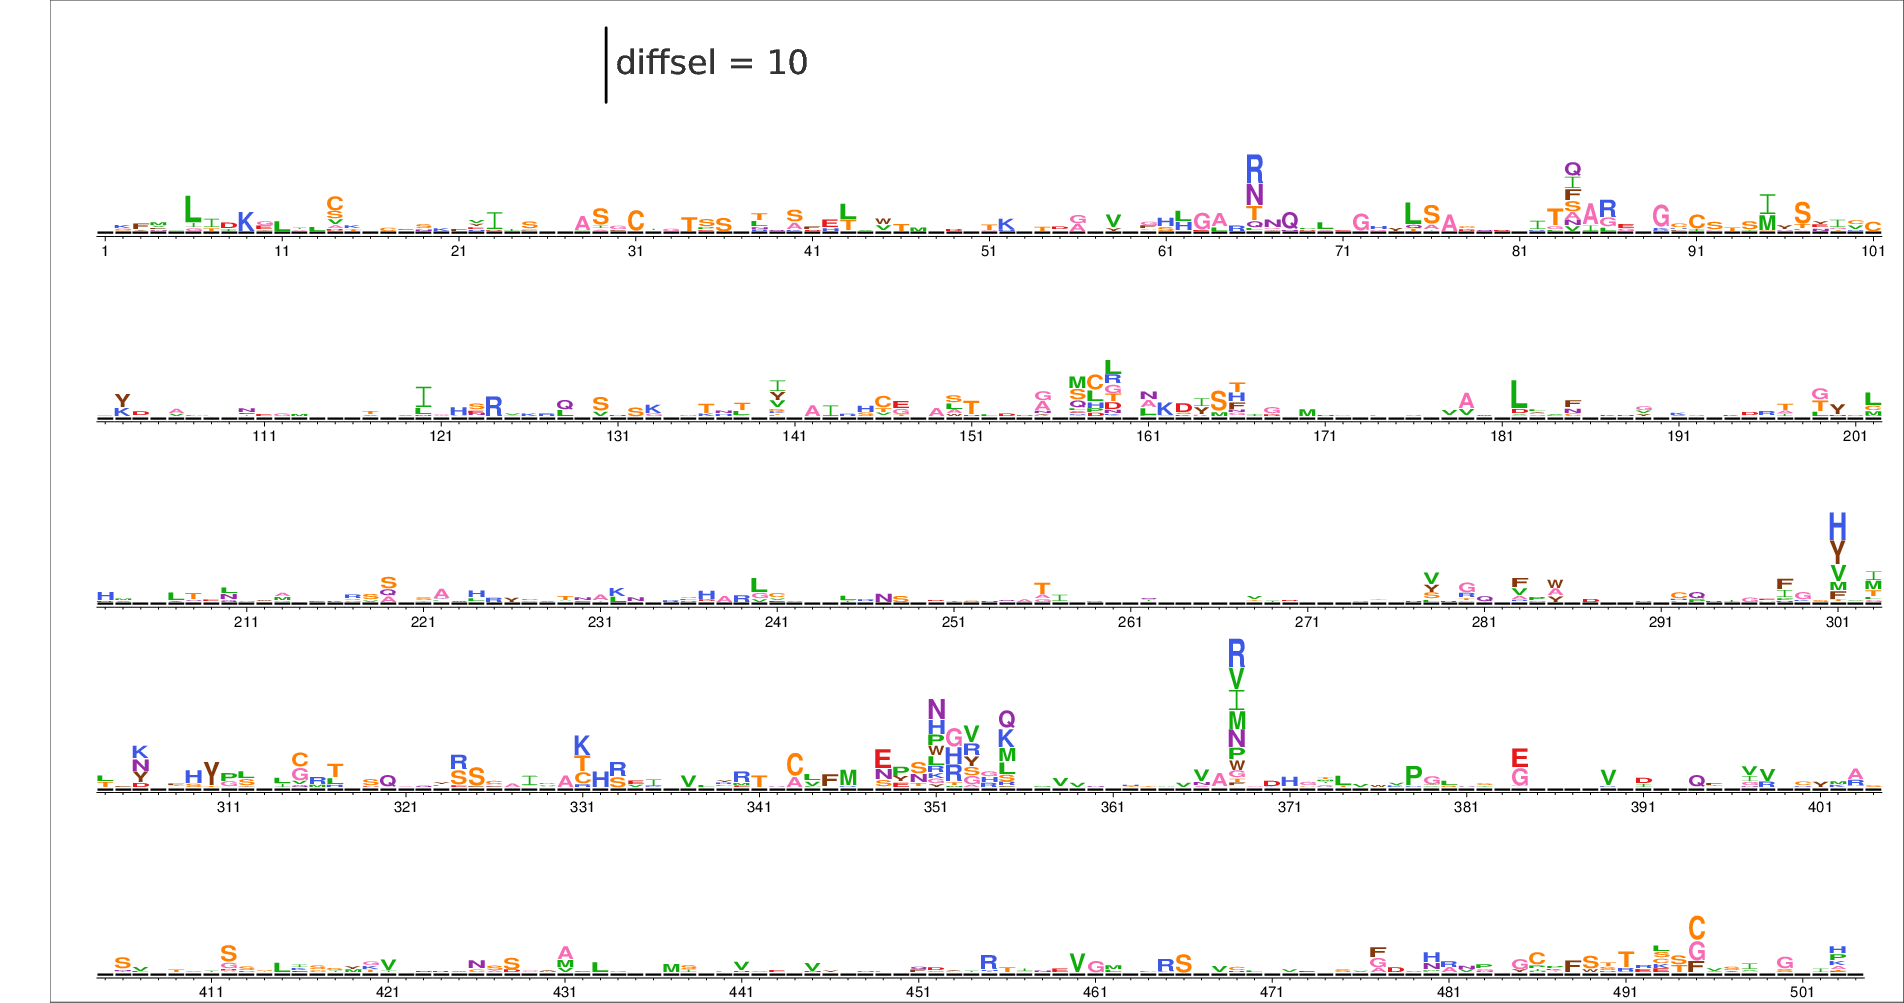

logoplot for ZKA64-750 shown below, saved to ./results/logoplots/ZKA64-750_diffsel.pdf


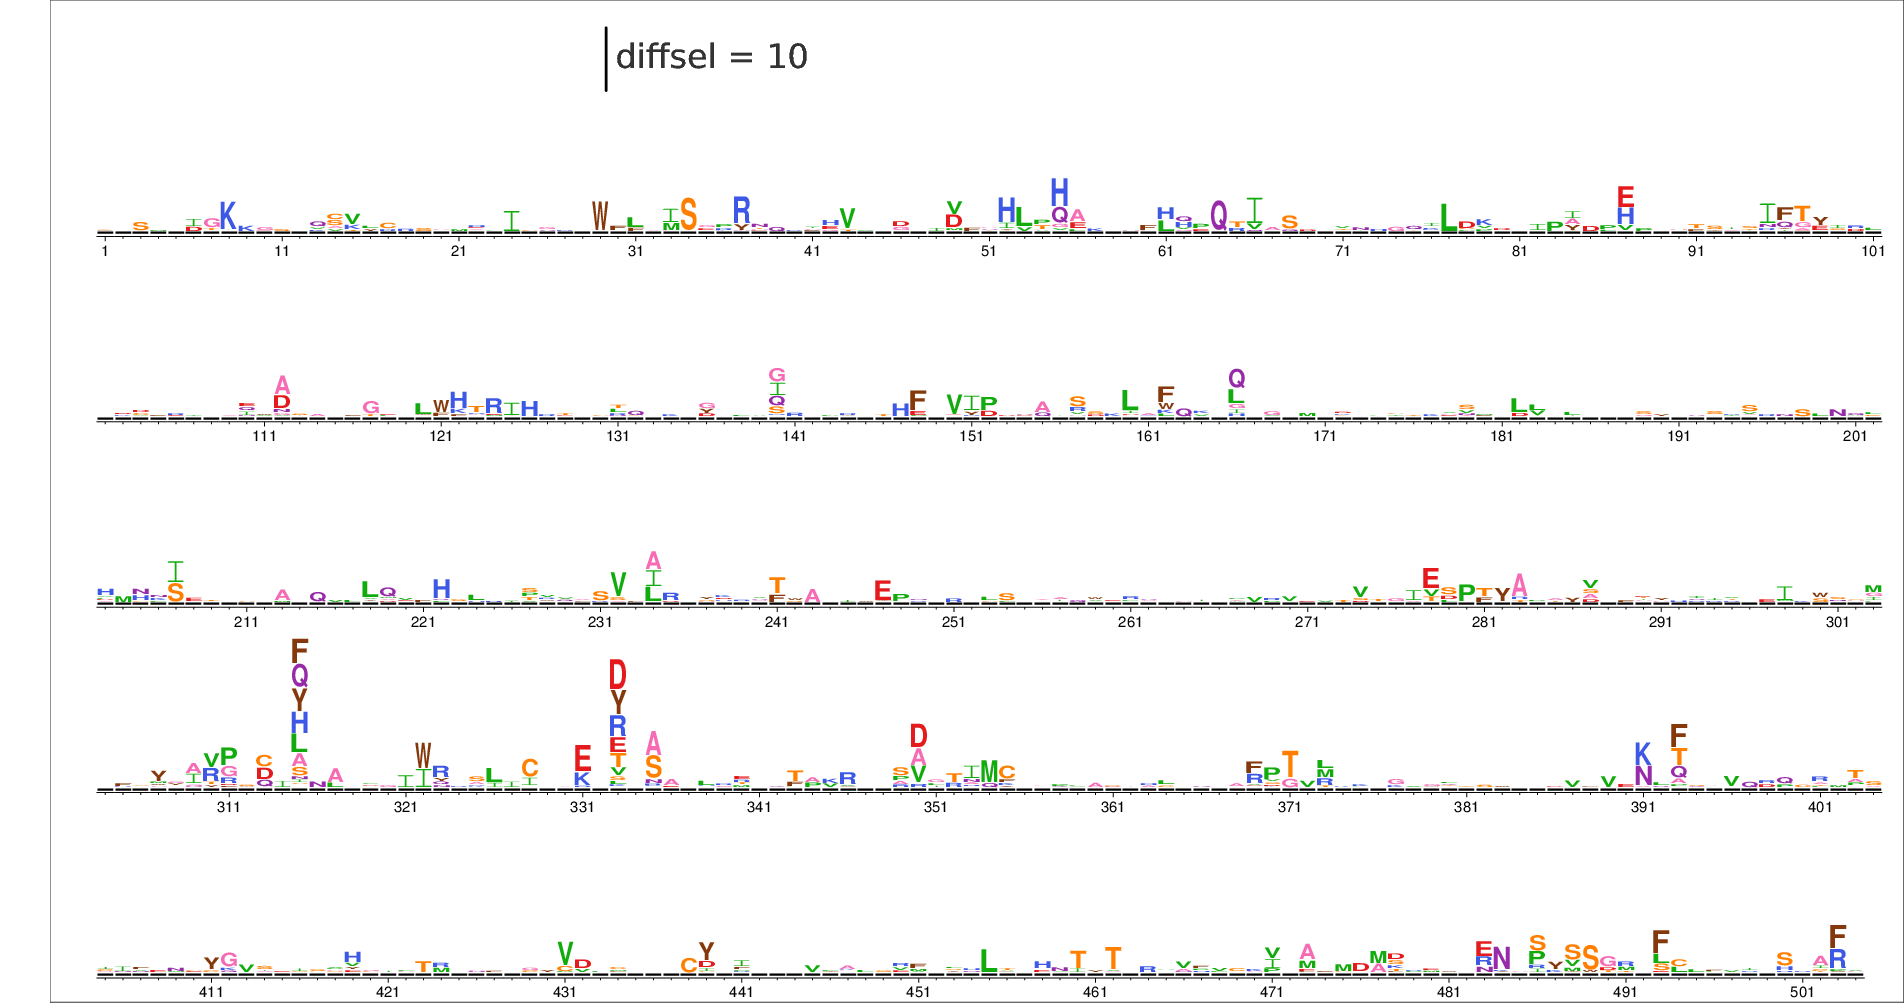

logoplot for ZV67-40000 shown below, saved to ./results/logoplots/ZV67-40000_diffsel.pdf


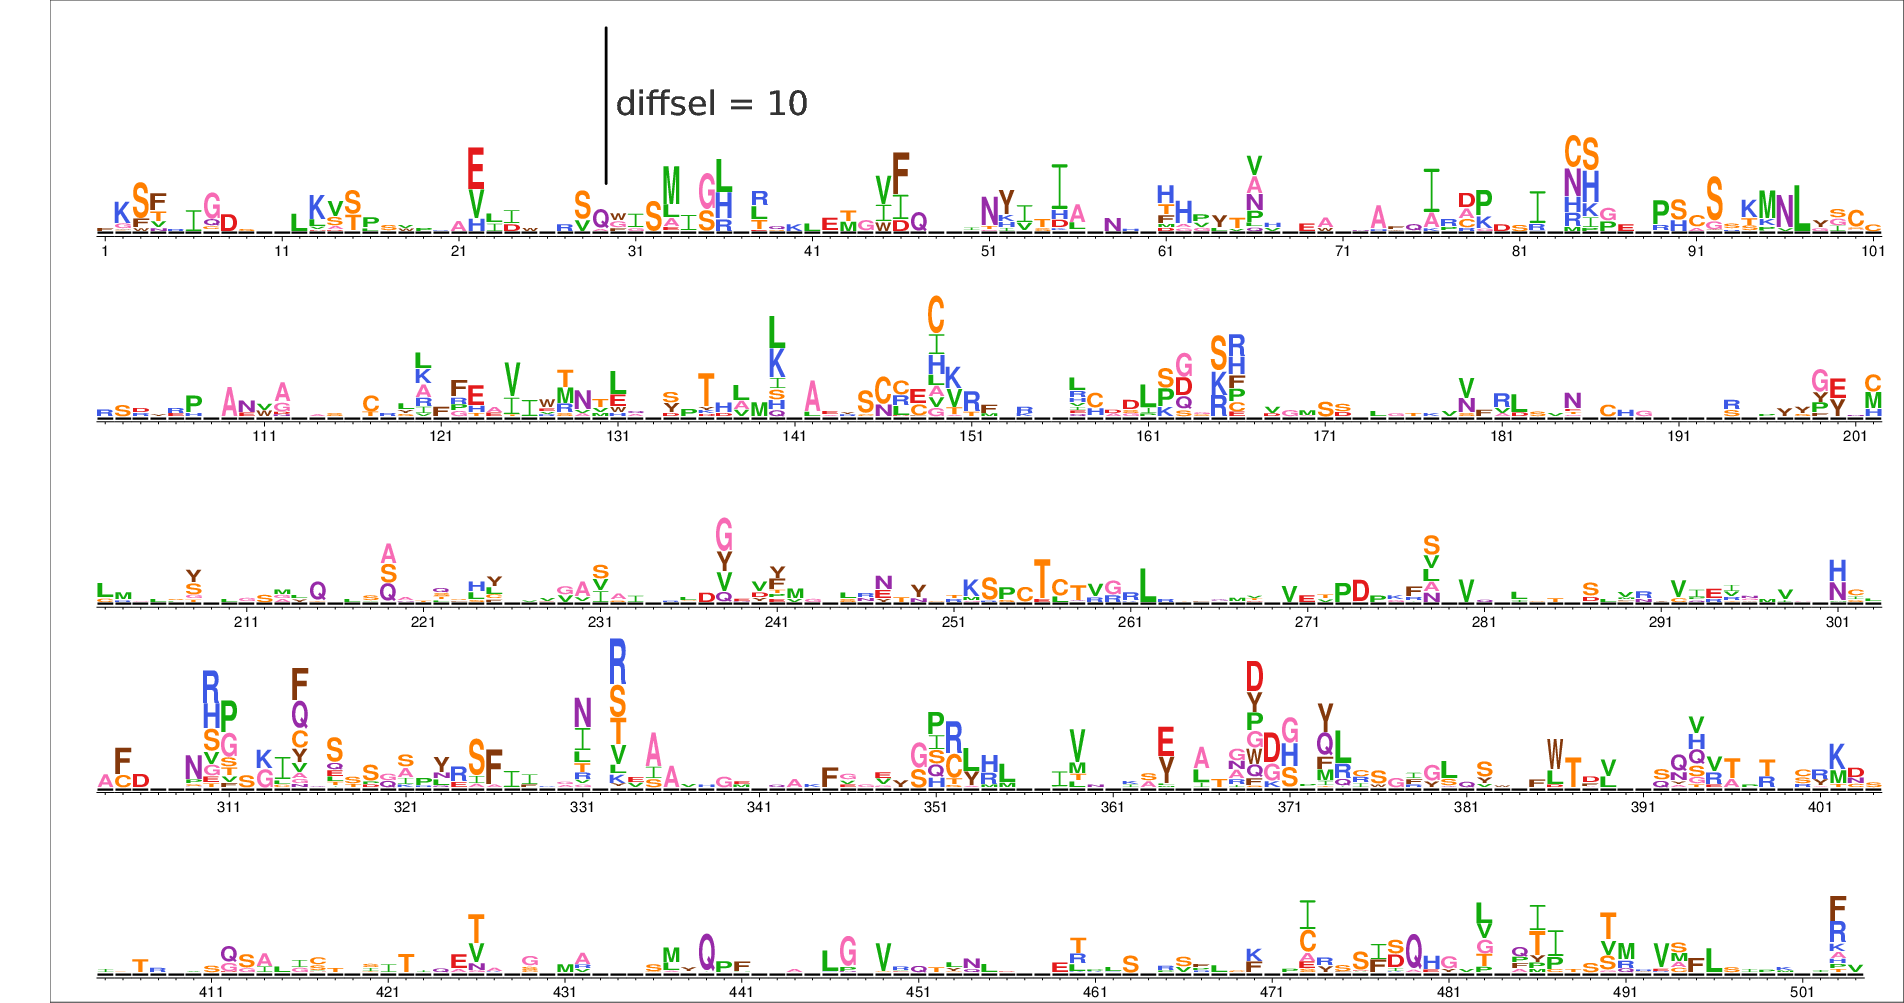

logoplot for ZV67-80000 shown below, saved to ./results/logoplots/ZV67-80000_diffsel.pdf


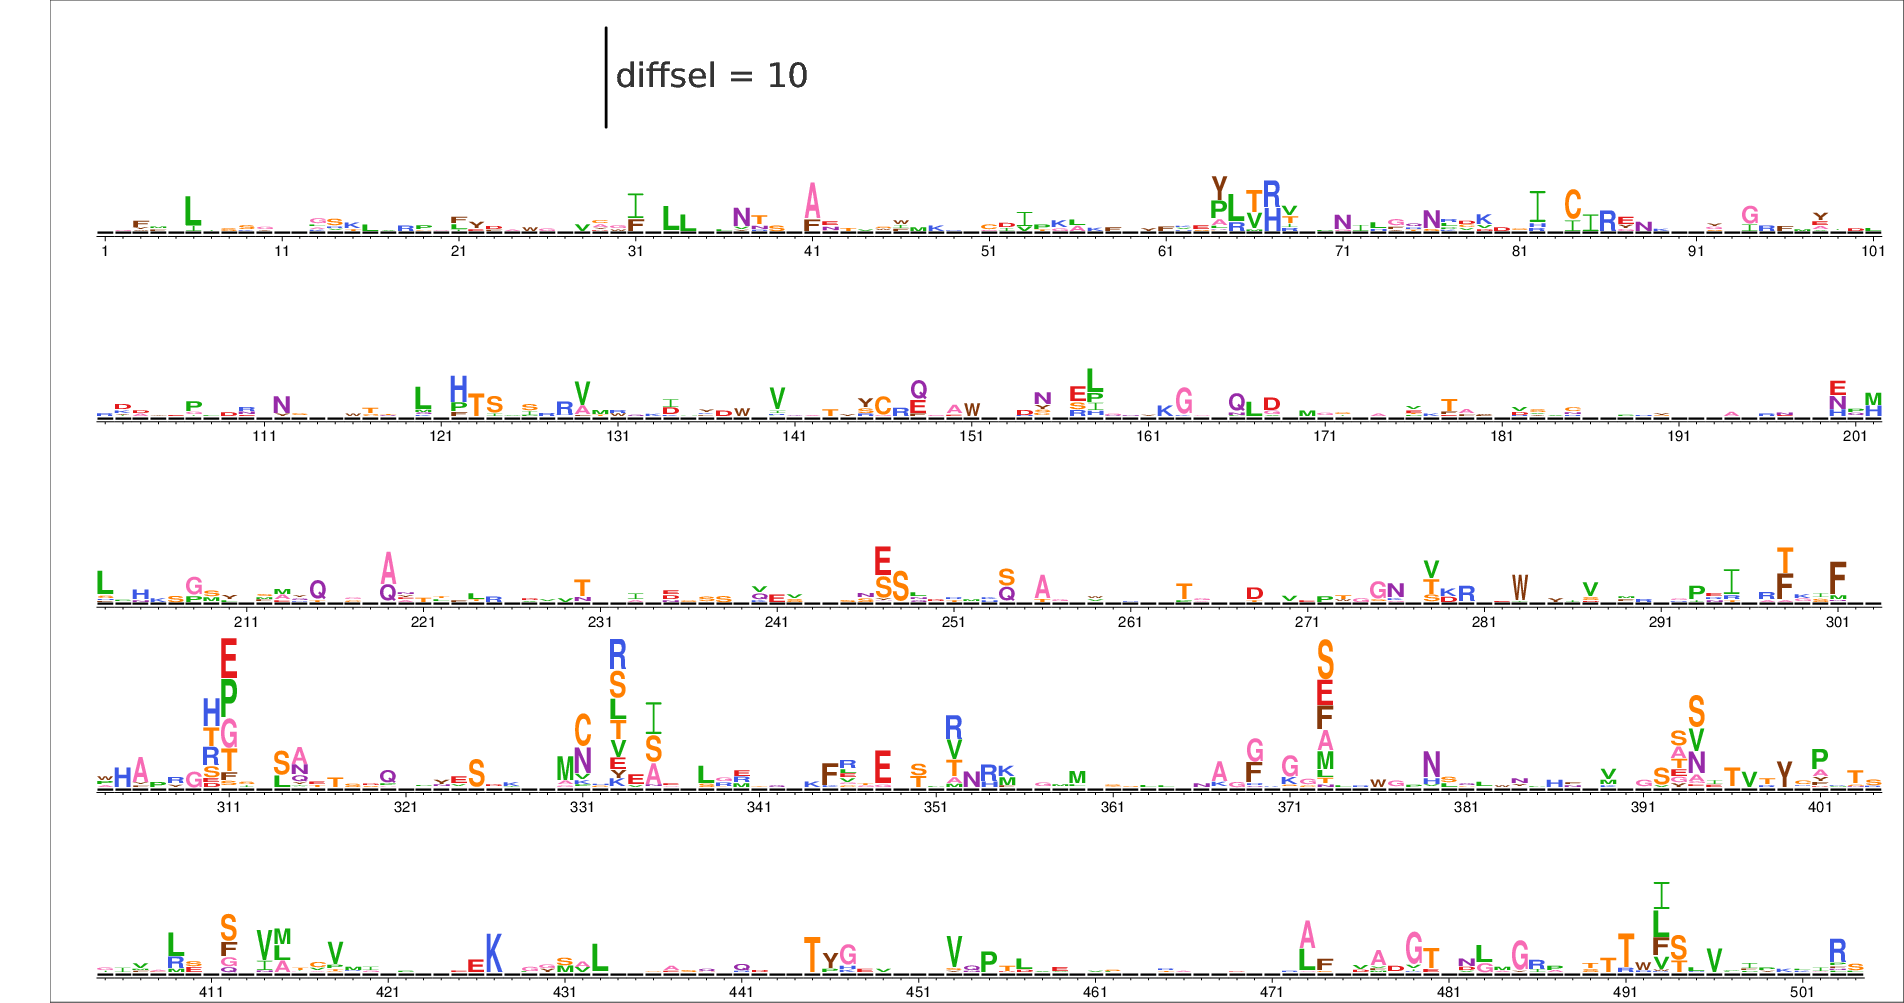

In [39]:
# show logoplot results for each concentration
for sample in diffsel_batch.name.unique():
    print(f'logoplot for {sample} shown below, saved to ' + os.path.join(logo_dir, sample + '_diffsel.pdf'))
    showPDF(os.path.join(logo_dir, sample + '_diffsel.pdf'))

## Create `dms-view` input files
We can create files to visualize our DMS results on protein structure using [dms-view](https://dms-view.github.io).
To do this, we will require E protein PDB structures. These were files were selected in the JV-2019 paper and I am using the same set of inputs here. I'll start with just 5IRE, published in [Science (2016)](https://www.science.org/doi/10.1126/science.aaf5316).

The PDB files contain 3 chains of 504 aa E protein -- previous JV-2019 analysis has only examined E monomer structure (A chain only). I will attempt to show all 3 chains. 

In [33]:
# for individual concentrations of each antibody
diffsel_files = (grouped_diffsel_batch
                 .assign(path = lambda x: grouped_diffsel_dir + '/' + x['group'] + '-' + x['name'] + '_mutdiffsel.csv')
                 [['name', 'path']]
                 .set_index('name')
                )
                        
diffsel_files

# for grouped will need to do this for median and mean diffsel

,path
name,
C10-150,./results/grouped_diffsel/EDE1-C10-C10-150_mut...
C10-300,./results/grouped_diffsel/EDE1-C10-C10-300_mut...
C8-1600,./results/grouped_diffsel/EDE1-C8-C8-1600_mutd...
C8-800,./results/grouped_diffsel/EDE1-C8-C8-800_mutdi...
MZ4-1200,./results/grouped_diffsel/MZ4-MZ4-1200_mutdiff...
MZ4-2400,./results/grouped_diffsel/MZ4-MZ4-2400_mutdiff...
MZ4-4800,./results/grouped_diffsel/MZ4-MZ4-4800_mutdiff...
ZKA64-750,./results/grouped_diffsel/ZKA-64-ZKA64-750_mut...
ZV67-40000,./results/grouped_diffsel/ZV-67-ZV67-40000_mut...


In [41]:
# make dms-view data files
# these should contain sites, wt, mutation, condition 
# as well as the PDB file protein_chain and protein_site
# these will include mut_* values since we are interested in mapping escape mutants

# make dataframe for all conditions/concentrations with site, wt, mut and mutdiffsel values
dms_view_df = pd.DataFrame()

protein_chain_ls = ['A', 'C', 'E']
protein_chain_df = pd.DataFrame()

for name, path in diffsel_files.iterrows():
    csv = path.str.split('/t')[0]
    dms_view_df = (dms_view_df
                   .append(pd.read_csv(csv[0])
                           .melt(id_vars = ['site', 'wildtype', 'mutation'],
                                 value_vars = ['mutdiffsel'],
                                 value_name = 'mutdiffsel')
                           [['site','wildtype','mutation','mutdiffsel']]
                           .assign(condition = name)
                           .sort_values(by = ['site'])
                           .reset_index(drop=True)
                          )
                  )
    
# add protein_chain and protein_site information
for item in protein_chain_ls:
    protein_chain_df = (protein_chain_df
                        .append(dms_view_df
                                .assign(protein_site = lambda x: x['site'],
                                        protein_chain = item)
                               )
                        [['site','protein_chain','protein_site']]
                       )
    
# sadly sort of hacky way to make these fit together
dms_view_df = dms_view_df.append(dms_view_df).append(dms_view_df)
    
dms_view_df = (dms_view_df
               .assign(protein_chain = protein_chain_df.protein_chain,
                      protein_site = protein_chain_df.protein_site)
              .dropna())

# save these files and preview dataframe
dms_view_dir = os.path.join(resultsdir, 'dms_view')
os.makedirs(dms_view_dir, exist_ok=True)

dms_view_csv = os.path.join(dms_view_dir, 'data.csv')
print(f"Writing CSV to {dms_view_csv}; here is a preview...")

dms_view_df.to_csv(dms_view_csv, index=False, float_format='%.3g')
dms_view_df

Writing CSV to ./results/dms_view/data.csv; here is a preview...


,site,wildtype,mutation,mutdiffsel,condition,protein_chain,protein_site
0,1,I,R,0.000312,C10-150,A,1
1,1,I,N,-0.236195,C10-150,A,1
2,1,I,T,-0.884634,C10-150,A,1
3,1,I,L,-1.649367,C10-150,A,1
4,1,I,P,0.000312,C10-150,A,1
...,...,...,...,...,...,...,...
10074,504,A,V,0.020708,ZV67-80000,E,504
10075,504,A,D,-0.260286,ZV67-80000,E,504
10076,504,A,L,0.223965,ZV67-80000,E,504
10077,504,A,S,0.741360,ZV67-80000,E,504
